# 데이터 증강

In [138]:
import os
import shutil
import random
import albumentations as A
import cv2
import numpy as np
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
from collections import defaultdict

# 데이터 증강 테스트

In [149]:
# 증강 함수
def augment_image(image_path):
    # 이미지 로드 (OpenCV는 BGR로 로드되므로 RGB로 변환)
    image = cv2.imread(image_path)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.add(image, 50)
    
    # Albumentations 변환 정의
    transform = A.Compose([
        A.CLAHE(clip_limit=4, tile_grid_size=(8, 8), p=1),
        A.HorizontalFlip(p=1),  # 좌우 반전
        A.Rotate(limit=15, p=1),  # -40도 ~ +40도 회전
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=1),  # 밝기 및 대비 조정
        A.HueSaturationValue(hue_shift_limit=100, sat_shift_limit=100, val_shift_limit=50, p=1),  # 색감 조정
        A.GaussNoise(std_range=(0.2, 0.2), mean_range=(0.0, 0.0), per_channel=True, noise_scale_factor=1, p=0.8),  # 가우시안 노이즈 추가
        A.CoarseDropout(num_holes_range=(200, 400), hole_height_range=(0.01, 0.01), hole_width_range=(0.01, 0.01), fill=255, p=0.8),    # white rectangle
        A.RandomCrop(height=image.shape[0] - 20, width=image.shape[1] - 20, p=1),  # 랜덤 크롭 (20px 제거)
        ToTensorV2()  # PyTorch 텐서 변환
    ])
    # 증강 적용
    augmented = transform(image=image)
    augmented_image = augmented["image"].permute(1, 2, 0).numpy()  # (H, W, C) 형태로 변환
    
    return image, augmented_image


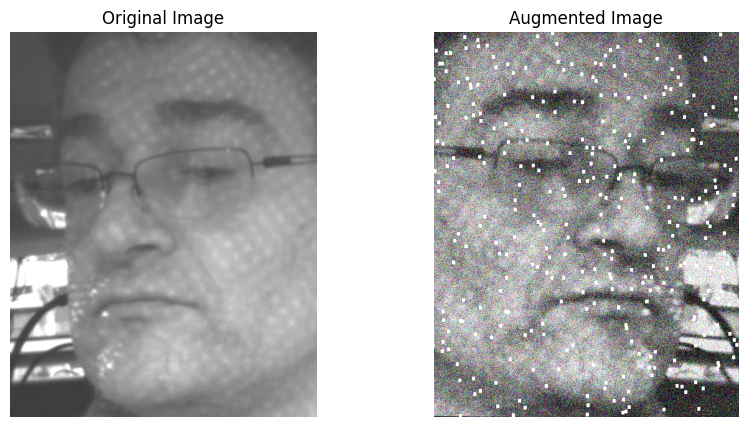

In [153]:
# 증강된 이미지 확인 함수
def visualize_augmentation(image_path):
    original, augmented = augment_image(image_path)
    
    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    axes[1].imshow(augmented)
    axes[1].set_title("Augmented Image")
    axes[1].axis("off")
    
    plt.show()


# 이미지 경로 입력
image_path = "/Users/taeheon/driver_monitoring/test_a.jpg"
visualize_augmentation(image_path)

# 증강된 데이터 저장
- train data에만 저장
- 형식 : **{원본 파일명}\_{aug}_{i}.jpg**

In [156]:
import os
import glob
import cv2
import albumentations as A
import numpy as np
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from collections import defaultdict

# 증강할 클래스 리스트
target_classes = [0, 2]

# 디렉토리가 존재하지 않으면 생성하는 함수
def ensure_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

# 클래스별 데이터 개수를 출력하는 함수
def count_class_distribution(label_dir):
    class_counts = defaultdict(int)
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(label_dir, label_file), 'r') as file:
                for line in file:
                    class_id = int(line.split()[0])
                    class_counts[class_id] += 1
    return class_counts

# 데이터 증강을 적용하는 함수 (바운딩 박스 변형 포함)
def apply_augmentation(image_path, label_path, save_dir_img, save_dir_lbl, aug_factor):
    image = cv2.imread(image_path)
    h, w, _ = image.shape
    image = cv2.add(image, 50)
    
    with open(label_path, 'r') as file:
        labels = file.readlines()
    
    bboxes = []
    class_labels = []
    
    for line in labels:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center, y_center, width, height = map(float, parts[1:])
        x_min = (x_center - width / 2) * w
        y_min = (y_center - height / 2) * h
        x_max = (x_center + width / 2) * w
        y_max = (y_center + height / 2) * h
        bboxes.append([x_min, y_min, x_max, y_max])
        class_labels.append(class_id)
    
    transform = A.Compose([
        A.CLAHE(clip_limit=4, tile_grid_size=(8, 8), p=1),
        A.HorizontalFlip(p=1),  # 좌우 반전
        A.Rotate(limit=15, p=1),  # -40도 ~ +40도 회전
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=1),  # 밝기 및 대비 조정
        A.HueSaturationValue(hue_shift_limit=100, sat_shift_limit=100, val_shift_limit=50, p=1),  # 색감 조정
        A.GaussNoise(std_range=(0.2, 0.2), mean_range=(0.0, 0.0), per_channel=True, noise_scale_factor=1, p=0.8),  # 가우시안 노이즈 추가
        A.CoarseDropout(num_holes_range=(200, 400), hole_height_range=(0.01, 0.01), hole_width_range=(0.01, 0.01), fill=255, p=0.8),    # white rectangle
        A.RandomCrop(height=image.shape[0] - 20, width=image.shape[1] - 20, p=1),  # 랜덤 크롭 (20px 제거)
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))
    
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    
    for i in range(aug_factor):
        augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_img = augmented["image"]
        aug_bboxes = augmented["bboxes"]
        
        aug_img_path = os.path.join(save_dir_img, f"{base_name}_aug_{i}.jpg")
        cv2.imwrite(aug_img_path, aug_img)
        
        aug_lbl_path = os.path.join(save_dir_lbl, f"{base_name}_aug_{i}.txt")
        with open(aug_lbl_path, 'w') as file:
            for bbox, class_id in zip(aug_bboxes, class_labels):
                x_min, y_min, x_max, y_max = bbox
                x_center = ((x_min + x_max) / 2) / w
                y_center = ((y_min + y_max) / 2) / h
                width = (x_max - x_min) / w
                height = (y_max - y_min) / h
                file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

# 데이터 증강 수행 함수
def augment_dataset(source_img_dir, source_lbl_dir, target_img_dir, target_lbl_dir):
    ensure_dir(target_img_dir)
    ensure_dir(target_lbl_dir)
    
    print(f"클래스별 데이터 개수 (증강 전): {count_class_distribution(source_lbl_dir)}")
    
    img_files = [f for f in os.listdir(source_img_dir) if f.lower().endswith(('.jpg'))]
    
    for img_file in tqdm(img_files, desc=f"Augmenting {source_img_dir.split('/')[-2]} Dataset"):
        label_file = os.path.splitext(img_file)[0] + ".txt"
        lbl_path = os.path.join(source_lbl_dir, label_file)
        img_path = os.path.join(source_img_dir, img_file)
        
        if not os.path.exists(lbl_path):
            print(f"⚠️ [경고] 해당하는 라벨 파일 없음: {lbl_path}")
            continue
        
        with open(lbl_path, "r") as file:
            labels = file.readlines()
        
        if not labels:
            print(f"⚠️ [경고] 라벨 파일이 비어 있음: {lbl_path}")
            continue
        
        contains_target_class = any(int(line.strip().split()[0]) in target_classes for line in labels)
        
        if contains_target_class:
            print(f"✅ 증강 진행: {img_path}")
            apply_augmentation(img_path, lbl_path, target_img_dir, target_lbl_dir, 3)
        else:
            continue

    print(f"클래스별 데이터 개수 (증강 후): {count_class_distribution(target_lbl_dir)}")

# 원본 데이터셋 경로 설정
source_dirs = {
    "train": ("/Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/", 
               "/Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/labels/")
}

# train 데이터만 증강 수행
src_img_dir, src_lbl_dir = source_dirs["train"]
augment_dataset(src_img_dir, src_lbl_dir, src_img_dir, src_lbl_dir)


클래스별 데이터 개수 (증강 전): defaultdict(<class 'int'>, {1: 6303, 4: 4312, 5: 2294, 3: 13946, 2: 835, 0: 2154})


Augmenting images Dataset:  14%|█▎        | 4042/29842 [00:01<00:06, 3689.58it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s1_ir_face_mp4-105_jpg.rf.08b5aefdf8b993ece8cff919d218444d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s1_ir_face_mp4-105_jpg.rf.8ba961cf141e9fc599deed3024ce2191.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s1_ir_face_mp4-105_jpg.rf.962864dc1e884f5ab685cc428ed072f7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s1_ir_face_mp4-105_jpg.rf.bc975f9790f9596cb78c492b9d362696.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s1_ir_face_mp4-105_jpg.rf.d7d3e391b73a0f34163b49c71f25ab9d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s1_ir_face_mp4-106_jpg.rf.1542b60a15693065ae98c4ab04ebd347.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s1_ir_face_mp4-106_jpg.rf.4e9b017a4869dc0a9322e7366c6a8

Augmenting images Dataset:  15%|█▍        | 4411/29842 [00:04<01:06, 381.12it/s] 

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s1_ir_face_mp4-150_jpg.rf.e65979fe51b68be241ed4815e6b1ec58.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s1_ir_face_mp4-215_jpg.rf.01fba9bcfdf497d54530e63f0ab41e01.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s1_ir_face_mp4-215_jpg.rf.25350d6a41c7bdf8a3d0311796ec8720.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s1_ir_face_mp4-215_jpg.rf.36c0cc1041aab2ae77d9735942943be4.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s1_ir_face_mp4-215_jpg.rf.8700c36311856788efc8b19450328ef6.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s1_ir_face_mp4-215_jpg.rf.e4546b7c5d7fa4dfb13e71a6fb85c6c1.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s1_ir_face_mp4-215_jpg.rf.ec359278fe0e7ad828b1812142fe8

Augmenting images Dataset:  16%|█▌        | 4672/29842 [00:05<01:25, 294.28it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s1_ir_face_mp4-50_jpg.rf.255779ebc550d51bdcf989f9252ae06c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s1_ir_face_mp4-50_jpg.rf.6a4a3cb75dd383c9a9f062c4a78b7044.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s1_ir_face_mp4-50_jpg.rf.8cc01243ddb8af51f717828be418b16e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s1_ir_face_mp4-50_jpg.rf.d6348bb05d526c58e2546c6f7e801cff.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s1_ir_face_mp4-50_jpg.rf.d85907dddea94357e8b621670cc40b77.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s1_ir_face_mp4-50_jpg.rf.e5f0bfd9778ca46640da6cba9c2fc814.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s1_ir_face_mp4-51_jpg.rf.409308f982d39453e128886b6f514ea2.jpg

Augmenting images Dataset:  17%|█▋        | 5074/29842 [00:07<01:37, 254.50it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s1_ir_face_mp4-57_jpg.rf.da2ccd933bd4063734516e737235a80a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-136_jpg.rf.96021422de7310e719555aab7fe82dc7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-137_jpg.rf.052addc8f1d185fe49d986210150d2ef.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-138_jpg.rf.3b8f5bb759cbec544c5b857c03e2698f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-139_jpg.rf.23c77af0023187f9457fdb4313171e90.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-141_jpg.rf.871c5cb0f3c372c00ebf4381ebe73b4c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-142_jpg.rf.503fe1c605badd396a43789dc0bc3d

Augmenting images Dataset:  18%|█▊        | 5395/29842 [00:10<02:07, 191.72it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-261_jpg.rf.d1b8f611f58acba4f43e480108d14626.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-264_jpg.rf.a01bcf7fa038cf83f7acbcbed8dbd4bd.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-265_jpg.rf.cfb9d61ee3be1dd4d13256ba21f0a997.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-271_jpg.rf.29e51fb5bfd285ba12cb8741b2dc57df.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-272_jpg.rf.d39f4378719e918308c4cdc6e1d7b1c0.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-273_jpg.rf.d3481eaf2115a4cf3c9fe0d2aaeaab5d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-274_jpg.rf.fc6602cb1989fc3f534f05d3d75b6

Augmenting images Dataset:  19%|█▉        | 5636/29842 [00:12<02:27, 164.62it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-351_jpg.rf.bdca34c4103c831cb2d556ae2ac8ce59.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-355_jpg.rf.81a276d0d6fff49c733065fbdc2423ae.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-357_jpg.rf.050d65a80768359ba2e8a7e99bab96aa.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-358_jpg.rf.6b200c96def0974cbbcd248008e3a06e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-359_jpg.rf.f51713fc45954c525283f57c90885de5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-360_jpg.rf.2f1425a6ceaedd4b647b3b01c3810b95.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-361_jpg.rf.25ce11517b350cb0f52724d81a376

Augmenting images Dataset:  19%|█▉        | 5713/29842 [00:15<04:11, 96.13it/s] 

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-399_jpg.rf.ce97aec5fb566243634c245a585dbfe0.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-442_jpg.rf.aad1311cac1c930b7d6499b2550d3926.jpg


Augmenting images Dataset:  20%|█▉        | 5825/29842 [00:15<03:14, 123.60it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-57_jpg.rf.5bd7efdbd0a23e09926e81ea73d81621.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-58_jpg.rf.a6cdf322e5909be288e58d7464e9f2b4.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-60_jpg.rf.f12280072ef68d33d4f5fc9add199bed.jpg


Augmenting images Dataset:  20%|█▉        | 5886/29842 [00:15<03:13, 123.73it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-61_jpg.rf.b07025f382afa778da092c4566374062.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-64_jpg.rf.b158b051c619a66da9e43c95e462ac4f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-65_jpg.rf.fe3c854786668b3f0380e01d119dc702.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-66_jpg.rf.0b8ca9959e48d4906cdfe1ea04f484d7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-67_jpg.rf.883e6819c59c7b4fe9433c7c96b8aa68.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-69_jpg.rf.97bde7b8841e62f8adc45d776a76c544.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_1_s2_ir_face_mp4-70_jpg.rf.047aee9b15115c878ad2b2c7c04853ac.jpg

Augmenting images Dataset:  24%|██▎       | 7083/29842 [00:17<00:29, 764.29it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s1_ir_face_mp4-161_jpg.rf.0162ce4fad27a1b049a1395e824057d2.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s1_ir_face_mp4-161_jpg.rf.68797afd1a1734b66097b6eee6a2f012.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s1_ir_face_mp4-161_jpg.rf.8489fb91bc47589b5c95b0955e2c1a05.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s1_ir_face_mp4-161_jpg.rf.8d022b4b385d34d7e412bd2d3b7d2f5c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s1_ir_face_mp4-161_jpg.rf.dd57ce6bfaf32477d504d8d35188b6b9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s1_ir_face_mp4-161_jpg.rf.ed60b6d2c2f6ce4efdf35ffffccd94d7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s1_ir_face_mp4-162_jpg.rf.06141a9ff87a43a8fc20d2523349e

Augmenting images Dataset:  24%|██▍       | 7290/29842 [00:18<00:58, 387.83it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s1_ir_face_mp4-164_jpg.rf.9ff8be6476237cd68563306103a4d5f6.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s1_ir_face_mp4-246_jpg.rf.4beb67906cef1f7b16e0b89472ccab32.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s1_ir_face_mp4-246_jpg.rf.4d2c5923ed7bea2fc2c799ff2861abe4.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s1_ir_face_mp4-246_jpg.rf.5e1bdcca696e81bb45d2de4213feb345.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s1_ir_face_mp4-246_jpg.rf.9335e096daa47454a785f2e024584f31.jpg


Augmenting images Dataset:  25%|██▍       | 7440/29842 [00:19<01:01, 364.14it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s1_ir_face_mp4-246_jpg.rf.bad4eaaf86de8ade27fc35c7da39fb7e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s1_ir_face_mp4-246_jpg.rf.e89f8507e0a34fb817e0e464afb049e0.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s1_ir_face_mp4-63_jpg.rf.047c4b438c01c8d7d68c03a186580883.jpg


Augmenting images Dataset:  25%|██▌       | 7579/29842 [00:19<00:51, 429.33it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s1_ir_face_mp4-63_jpg.rf.4e00257cb379db0d9ce24bc322a4c9d9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s1_ir_face_mp4-63_jpg.rf.8c5a34a9e5864409c0deb3027399816a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s1_ir_face_mp4-63_jpg.rf.a3731f8502ab5033a777fb4fe281cd67.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s1_ir_face_mp4-63_jpg.rf.f06f2ce7f2d8cfee9f1e71bc67da7f1f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s1_ir_face_mp4-63_jpg.rf.fc28f4f45f066c719569a2554caedc29.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s1_ir_face_mp4-64_jpg.rf.0d93afb11aa01abe05b5fdc35be880de.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s1_ir_face_mp4-64_jpg.rf.1f7840e0ec63bec2b4c06d6100f353dd.jpg

Augmenting images Dataset:  26%|██▌       | 7694/29842 [00:20<01:27, 254.16it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-101_jpg.rf.248a09464788c78f0bdbfb2141dca630.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-103_jpg.rf.68ef88f69da8f492bb4f4ca92a2c4633.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-104_jpg.rf.45f45d72d3a61c07637d42b31daba761.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-106_jpg.rf.43f72112a9f6e39e263af8babd47889d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-107_jpg.rf.d879f696deb00e9bacc9319ef0e2e7a1.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-108_jpg.rf.c4e16cba991135923374d34a58ac1412.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-109_jpg.rf.2a3df845f25aa4c6ff745fb699824

Augmenting images Dataset:  26%|██▌       | 7777/29842 [00:21<01:56, 189.60it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-113_jpg.rf.4c7f33bfede9d2e1e922473df5648c0a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-116_jpg.rf.6cb0518d1775979c1c081a08adb7f7a6.jpg


Augmenting images Dataset:  27%|██▋       | 7939/29842 [00:21<01:23, 262.07it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-168_jpg.rf.3c72951cd746531b3958f8b444f8d95a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-169_jpg.rf.f62c86fc9cdc470dd075d28f7000b504.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-171_jpg.rf.4de6a970b4c91ba581b7bbb50eefab80.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-172_jpg.rf.5184d810e650809ce327597f1cb2a663.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-175_jpg.rf.93491f844b0a3884df9b37a3e190d868.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-177_jpg.rf.f08b3925e86139d85d488bfe9c19c760.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-180_jpg.rf.39cefb3c43eba655794e4e519b03d

Augmenting images Dataset:  27%|██▋       | 8178/29842 [00:24<02:27, 147.01it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-270_jpg.rf.7f690746378e20fd8bdfe5703f478ee3.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-272_jpg.rf.1b5a8383230ba7b5aec8c8e706e11cbe.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-274_jpg.rf.c752c52b36663d27ec3b16bcd86c7784.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-275_jpg.rf.116b61779cd275ba82c664bf7f4acf65.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-297_jpg.rf.0c256046902727dd2b35b6f80aa58ad7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-298_jpg.rf.2695da7626ac12b902ca87b4c490e286.jpg


Augmenting images Dataset:  28%|██▊       | 8242/29842 [00:25<02:24, 149.02it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-300_jpg.rf.b189b79d8cf1652d9f385b7ab793417a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-302_jpg.rf.e5981a21cdcd26827dbf279db6b00aac.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-304_jpg.rf.8005290bd44171fe703685aa3a892798.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-305_jpg.rf.dded6d5016929097b9229bbefedff369.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-306_jpg.rf.cd9c0e597b7a34260fb6919e4f5be7f3.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-307_jpg.rf.35551cbcbbc614348e187008404698bd.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-308_jpg.rf.8d3222d4d9504da2c6c072d6d86d7

Augmenting images Dataset:  28%|██▊       | 8292/29842 [00:27<04:56, 72.75it/s] 

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-339_jpg.rf.8e3515277608bab5e1ed6cc4ef3b7848.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-341_jpg.rf.26ab79a91584424488861f9dc3392148.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-343_jpg.rf.6adc7976f054aff3b3a85ba9bc4abbd5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-344_jpg.rf.4172fa50d4aff8496de1b98dd0ce642a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-345_jpg.rf.9d1cbf32c94ef79bd5c79e81a107895e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-346_jpg.rf.731a9e423695a1433e56524badcef6ad.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-348_jpg.rf.bd9afd59d9ba7f23544366ce5fac1

Augmenting images Dataset:  28%|██▊       | 8415/29842 [00:29<04:05, 87.20it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-366_jpg.rf.cce4207ff3335e82c139faeb545273d5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-394_jpg.rf.41c2451bedae87b988725911443c0b6b.jpg


Augmenting images Dataset:  28%|██▊       | 8471/29842 [00:29<03:20, 106.60it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-398_jpg.rf.6703da4aa007fa41dbaa886bbdda471f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-399_jpg.rf.93a7b7674c2c18938ed239408cb710c2.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-400_jpg.rf.788c50cc4d43801a34d913451d6634c8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-402_jpg.rf.415b3ecca14d074b15fb565859e229a1.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-403_jpg.rf.4225dce1f1307c9016bb167b382f50fb.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-404_jpg.rf.1628ac13a3559b61ff83e0f796579a17.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-405_jpg.rf.c363e2874e2ba359081d536e9d4df

Augmenting images Dataset:  29%|██▊       | 8515/29842 [00:31<06:31, 54.41it/s] 

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-432_jpg.rf.8af4b3598a6d80514d2e63dcb80401ba.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-433_jpg.rf.47dac3932845a8d4c15993f8b15a4333.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-435_jpg.rf.58f3a6dcb5c50739d530e1cfe1e1013b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-436_jpg.rf.0a2f737caa04ba49985e79f21b878225.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-437_jpg.rf.8f16a76e205260a79a534ccc544a5c4c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-438_jpg.rf.7b19d0fad34fd2379ae3daa2c803d304.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-440_jpg.rf.7abb7285b863e485e0602bdd67e0d

Augmenting images Dataset:  29%|██▉       | 8696/29842 [00:32<03:41, 95.36it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-485_jpg.rf.3e5083b9ba8516cc0f122e40583d699c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-56_jpg.rf.a7ae8984b85918cfa130d2f802addd5f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-60_jpg.rf.6803564c1b99f4235c3172d59b90c8c4.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-61_jpg.rf.0475830382802a07e82c8bf10ab7c9cc.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-62_jpg.rf.1882377833c4d0abde5e892a1bbb8ef8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-63_jpg.rf.ff7af4339413477ab166528299fb8252.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-64_jpg.rf.cccfc5abd34c916ec7df1fa7c66a5558.jp

Augmenting images Dataset:  29%|██▉       | 8757/29842 [00:35<06:08, 57.15it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-98_jpg.rf.b27b2712b259828d070b01b75677b648.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_2_s2_ir_face_mp4-99_jpg.rf.7b73c2c4ba8669bca7c649985b184f43.jpg


Augmenting images Dataset:  32%|███▏      | 9489/29842 [00:35<00:50, 405.10it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-115_jpg.rf.1b2dc7facd4d96746c9235042232af01.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-115_jpg.rf.48075bcd05fdfc4c5962ff3792c255e8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-115_jpg.rf.9e92a4469708fe91a548dfa62d79236b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-115_jpg.rf.a4ba73f28560b719461ce4e69b8d3eda.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-115_jpg.rf.a6ac142e184fb121a4b7294b0a0c38c4.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-115_jpg.rf.e8c9dcf856188e1ecc3070eb808622f8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-116_jpg.rf.59a4399d6273823a70ca1483014f0

Augmenting images Dataset:  33%|███▎      | 9745/29842 [00:37<01:22, 243.86it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-189_jpg.rf.0fd9f55e9586dea28ee7b0d1cca35e01.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-189_jpg.rf.185767cba85d3b1f56400e11a91debe9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-189_jpg.rf.792814fcf902823782460366e86b8b80.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-189_jpg.rf.e67c7eac50d8774a748c321f554ea91f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-190_jpg.rf.2c84768f2abf6963877e383595b55962.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-190_jpg.rf.740ba840d82531a43599b10c96033338.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-190_jpg.rf.77b244aaf59ba261c9f23f8180a78

Augmenting images Dataset:  33%|███▎      | 9841/29842 [00:40<03:06, 107.45it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-198_jpg.rf.cc256590fc406fa705768478dc0ef4ff.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-198_jpg.rf.ec42674de3fa029e140b2cbfaa825ffc.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-237_jpg.rf.1183baeddc596b3f6070c5254a2e6543.jpg


Augmenting images Dataset:  33%|███▎      | 9948/29842 [00:40<02:22, 139.55it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-237_jpg.rf.1d1680d4730e19e95cb318b585aac0a4.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-237_jpg.rf.48f3eb9432850c992fd366aaee823cf0.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-237_jpg.rf.602804d952d88f404845c40aeea9baf2.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-237_jpg.rf.dbaee33cd769e1155aa9709683ecc288.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-238_jpg.rf.08222c760bdbe1cfe34050162c07ed27.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-238_jpg.rf.7fd19e7ce841d2971052e9d8a84c5b17.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-238_jpg.rf.a556d46eaf29fde217e527aed1e80

Augmenting images Dataset:  34%|███▍      | 10135/29842 [00:43<03:06, 105.51it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-51_jpg.rf.35747e5f29720e19fb75752a950a86f9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-51_jpg.rf.54278e8ad49b06e57f1b28529825ed03.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-51_jpg.rf.68798e769dec08d8af5f4dc740b086c8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-51_jpg.rf.a2705e07d45931221f46f4ef8c84f316.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-51_jpg.rf.d94beb7dbcc4ea5218a20f57d2fcd28b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-51_jpg.rf.f41e76c55d05a98fd950aa7e3b2a9420.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s1_ir_face_mp4-54_jpg.rf.1d0d6c842d4500b2464b9e7ab936075e.jpg

Augmenting images Dataset:  35%|███▌      | 10452/29842 [00:44<01:37, 198.35it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-133_jpg.rf.649cb7a999db06fd5a91a443e82f6189.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-134_jpg.rf.e782db2a7c51df6f7ef88c7cd675c700.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-135_jpg.rf.803d0d3afebefd0c0a2f066bec3b7c9a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-136_jpg.rf.c295658f4dbe9cc98d84d6adb6981ecd.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-138_jpg.rf.4b67d2712d824166894c6546802f6df3.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-139_jpg.rf.f3b1dcca609f5112302c31e3f4a5f5e0.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-140_jpg.rf.9c8f8ff7f3a185133f33524b84fef

Augmenting images Dataset:  36%|███▌      | 10735/29842 [00:47<02:16, 139.94it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-172_jpg.rf.c1c809b92b5ff715e485584ad66f8868.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-246_jpg.rf.2ce7a42de8115a4a16910e7a3ee6dd47.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-249_jpg.rf.b42a1119d4278f60c33123faaf416fb9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-251_jpg.rf.77340a778c2e9a5e9501d995f251873c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-252_jpg.rf.d3cb4a48a84a01b56f12fe4e4c1cd7fa.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-253_jpg.rf.9da5385384a3594dd412e587b2fe2f98.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-255_jpg.rf.c53d113241778e5496fcf2108385f

Augmenting images Dataset:  36%|███▋      | 10841/29842 [00:49<03:20, 94.56it/s] 

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-284_jpg.rf.8c10860b880496df3eb9eb2d09a2e7ee.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-286_jpg.rf.c0ca6005dc243150f9994247bdbb2c65.jpg


Augmenting images Dataset:  37%|███▋      | 11004/29842 [00:49<02:17, 137.21it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-335_jpg.rf.9c824b12b9c30dcb3eedf26c708afb50.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-336_jpg.rf.fd30c34b0b29f9ac46871b0868807291.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-337_jpg.rf.d5bd5196ea67795c88b837da4fc00a3c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-338_jpg.rf.a627e9d3059d5448d4b60bad32e0cf8c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-340_jpg.rf.a80596da60fb45a292e0bcc261fda602.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-343_jpg.rf.5265225933bd1488f1c4b684c3f2fe5a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-345_jpg.rf.05831ed1b715f6ac96f9184569c9b

Augmenting images Dataset:  37%|███▋      | 11087/29842 [00:52<03:57, 78.86it/s] 

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-379_jpg.rf.c58789b9fd5a401eabd6f1bc25244f91.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-380_jpg.rf.a8971454bcd6cba8f51656e198957a17.jpg


Augmenting images Dataset:  38%|███▊      | 11277/29842 [00:52<02:29, 124.23it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-56_jpg.rf.4dbb27209e7b1019ea261719847ea9b5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-57_jpg.rf.fa40beb4bde685ef77a03ec298190695.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-59_jpg.rf.d767474157e39376fef759ee1c54083f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-60_jpg.rf.dd43056bcdc2c279be264bda843f27d8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-61_jpg.rf.0d0d2411a62c5b45ab448781eca8a406.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-64_jpg.rf.37821ff79d3c2c535b13eff4f4e8e1a3.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_3_s2_ir_face_mp4-65_jpg.rf.1702b9776e32c61888fff67f2f8b02bd.jpg

Augmenting images Dataset:  40%|███▉      | 11834/29842 [00:55<01:16, 235.86it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-147_jpg.rf.04af2151023f78055d39e1f4116c809b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-147_jpg.rf.32a48ee2cbaaaec0a15bb88ed4807cb4.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-147_jpg.rf.409b8c83d5fdb2210804dd73be0d1bb7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-147_jpg.rf.d696ab7753237aa7a45b649e0a45ebf4.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-147_jpg.rf.fd574583d371d157cf41432eeb9ed9aa.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-148_jpg.rf.00545840aa3c3875450f4809e28180d4.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-148_jpg.rf.4df641a0418fec65ca244d40a1499

Augmenting images Dataset:  40%|████      | 11948/29842 [00:57<01:59, 149.60it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-152_jpg.rf.b1b57ddbf4722f6686615fb80bcd1f3a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-152_jpg.rf.b3b234ca3fd21db02560e3cda611b0a5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-184_jpg.rf.1188f3bce8d83c6c5a2d563766b9cc8d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-184_jpg.rf.15b3801137374aa8be815fd82625ad0a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-184_jpg.rf.6b77439101a981393ad3eff8310f6e16.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-184_jpg.rf.83f1c5723efd6688a1f6b7a1f2a0c1fc.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-184_jpg.rf.bc95b997a8718f769e092cbda4144

Augmenting images Dataset:  40%|████      | 12030/29842 [00:58<02:14, 132.85it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-189_jpg.rf.eae710112414dd578926ef18228e8a33.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-232_jpg.rf.568f29bf2b78d55385be27c37d96cfeb.jpg


Augmenting images Dataset:  41%|████      | 12171/29842 [00:58<01:37, 180.64it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-232_jpg.rf.8c2586d03ec4b8977eb59f32a709e292.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-232_jpg.rf.9aea2a678caf7ca018c7b4cc7b82cfaa.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-232_jpg.rf.dc3d234f7bd8595fd9873e9872850e42.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-232_jpg.rf.fd8dc3612c54692032936ab711105729.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-234_jpg.rf.366067eb1fb094e13e5016e61e2b29eb.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-234_jpg.rf.65aa6a844c26c15b8cf9fef05b6fbe08.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-234_jpg.rf.992ffcd521c917c98ed3826967f88

Augmenting images Dataset:  41%|████      | 12246/29842 [00:59<02:02, 143.67it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-234_jpg.rf.feb97215c996ff15aac90f5f787c6b90.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-54_jpg.rf.106795c1c179e9c850c1f1fecfc9bf84.jpg


Augmenting images Dataset:  41%|████▏     | 12355/29842 [00:59<01:33, 186.54it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-54_jpg.rf.17c06a19d92ee6089f10254484460754.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-54_jpg.rf.40103e2b589729a4f985be187056494a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-54_jpg.rf.48a121a1c88c27fda5b96cbb431c96c5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-54_jpg.rf.8442c120e7f770efde9dd863a93a0be4.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-54_jpg.rf.bbbdfd31e4350bc09c5f8d4a2f82c3c8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-55_jpg.rf.1ed1bb5dc16a4d5a051a47661d38afa6.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s1_ir_face_mp4-55_jpg.rf.3ed96cca1fb1c92bf4fc9c6ec605560b.jpg

Augmenting images Dataset:  42%|████▏     | 12547/29842 [01:01<01:48, 159.25it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-101_jpg.rf.c5c5d3f1b06d1249f4a9bd396149fcd5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-102_jpg.rf.f1494ffc11d231b778ab567399913c6e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-103_jpg.rf.507e5b677bf26a4a3243ece7f81ca701.jpg


Augmenting images Dataset:  42%|████▏     | 12609/29842 [01:01<01:44, 164.25it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-103_jpg.rf.8c49a195e3706749f180128ba4197862.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-103_jpg.rf.8fde6ede71d576d49eed9328266b6947.jpg


Augmenting images Dataset:  43%|████▎     | 12741/29842 [01:01<01:12, 235.66it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-155_jpg.rf.4b5e2079e3cbb44e37fe4d1c0426f2cf.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-156_jpg.rf.49b84471fce90a863de61ad3bcb4e863.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-158_jpg.rf.3567a5263005ed437877c54462634235.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-159_jpg.rf.254ecfc4b922f0de2fd7f5a5dcf7ceeb.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-160_jpg.rf.d9563c063f63646142f78ad01611e5cb.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-161_jpg.rf.e40fae60ff3d906eb7583def423e61af.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-162_jpg.rf.6d04a49dd007366322fa651fe0a17

Augmenting images Dataset:  43%|████▎     | 12802/29842 [01:04<03:50, 73.81it/s] 

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-197_jpg.rf.ba68d75890f6a2e692687c8a84a249dc.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-198_jpg.rf.467a7a19dfbeb1d4c3ff03a172b40d33.jpg


Augmenting images Dataset:  44%|████▎     | 13032/29842 [01:04<01:57, 143.50it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-256_jpg.rf.6cb751adc3fc86ce34d79d7ba0cd0981.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-271_jpg.rf.2b576990b1c792502ea9e5d44f5dcfa9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-272_jpg.rf.8f3574b2fc23ded96745cb338220ad1d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-274_jpg.rf.d85da81ad17a549d4164f5e5bf693a1e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-275_jpg.rf.1b0ba8077a0c4a525cabe4794e8a6bbb.jpg


Augmenting images Dataset:  44%|████▍     | 13101/29842 [01:05<02:02, 136.64it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-277_jpg.rf.22ef582890f274a47e23bf964d44f99b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-278_jpg.rf.ff92e86d53789ccd46d61091b7f47970.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-279_jpg.rf.fed59e8e1db27f88dbe3005fc20eacc9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-280_jpg.rf.b8bd216b36c48466d38399cd8059966c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-283_jpg.rf.f5bd63e7f1c0940ff4a5ddc876e8d392.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-284_jpg.rf.392bd808aed8f4e3d40cbb8b81a32172.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-285_jpg.rf.602a20062d937ed2f9c9a66c1424e

Augmenting images Dataset:  44%|████▍     | 13153/29842 [01:07<03:45, 74.06it/s] 

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-310_jpg.rf.7151ca79774623c0a8f44159eebee3ec.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-311_jpg.rf.7f7f0b00ed68a43956f58561114f8d6d.jpg


Augmenting images Dataset:  45%|████▍     | 13335/29842 [01:08<02:11, 126.00it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-366_jpg.rf.3d2f30ae97c0403a102ee8248cde8311.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-367_jpg.rf.f6b250785b2ba59bcccee61960a163df.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-368_jpg.rf.a5251ac6a803888c5072a16bca811432.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-369_jpg.rf.9a0fc4cbe4d0ee149400a379c8231aac.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-371_jpg.rf.ee97993f4eecbcf257c973e1bcc200e8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-373_jpg.rf.652da687d2ce90b4f6f5a1ba9db63a41.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-374_jpg.rf.b8e9b5ce734b5781c6b0011192f1c

Augmenting images Dataset:  46%|████▌     | 13584/29842 [01:10<01:51, 145.24it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-58_jpg.rf.c39083f03051222544e019bbf6a629b6.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-59_jpg.rf.d5636e98453c411975a9d6e3616abdb5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-60_jpg.rf.4a1042e3aa066107f3ee8664c7819aca.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-61_jpg.rf.ad9c8b009026dbdd74a1e81297cffd97.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-62_jpg.rf.6b1c8e3797b9b17e6b6d8d7f2dfe31d9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-63_jpg.rf.7360aed388a875305e714c1cca1f4738.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-66_jpg.rf.0abf4810e2063753b2af84a84bda9eab.jpg

Augmenting images Dataset:  46%|████▌     | 13655/29842 [01:12<03:37, 74.54it/s] 

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_4_s2_ir_face_mp4-99_jpg.rf.e7f615408d1af5469f81b4e62402e340.jpg


Augmenting images Dataset:  47%|████▋     | 14054/29842 [01:13<01:21, 193.91it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-100_jpg.rf.3aabc8bdf8ac0f7b1ae7b97487a109e1.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-100_jpg.rf.785c3d063ed3f202ec622e3648c3c58b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-100_jpg.rf.8c985522fecb7aeeaf70452d43c1b967.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-100_jpg.rf.c6c1ec114586cae66056bc7be2842338.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-100_jpg.rf.eef4749e7aa346118e47dde37b796e29.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-100_jpg.rf.fb6508ffa8c5c32f88ce68ba1fe92873.jpg


Augmenting images Dataset:  48%|████▊     | 14175/29842 [01:13<01:13, 212.06it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-146_jpg.rf.1d248bc16f7f3717bad8ad1db4effcab.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-146_jpg.rf.b441e844178134267764639f04fde826.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-146_jpg.rf.dea75b44663fb7defe1cf3c0d8d57c6d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-146_jpg.rf.ea6470c81dc17ad7a322dfe6abf304b0.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-146_jpg.rf.f8fdeec3bc5bba00dd3f28f040656942.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-147_jpg.rf.622ed099d759b7ded34085f12c63f830.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-147_jpg.rf.6d326d70675f4dcd899d388496c08

Augmenting images Dataset:  48%|████▊     | 14269/29842 [01:14<01:26, 179.60it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-147_jpg.rf.ed22679ef7fec0aa139ebfd68f54f9ec.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-211_jpg.rf.986650d38efa440fa1a8e1f44c5a6214.jpg


Augmenting images Dataset:  49%|████▊     | 14517/29842 [01:14<00:51, 296.02it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-211_jpg.rf.99fd62135709eef1e3e79a732e8378f5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-211_jpg.rf.ab1bce5cf7ad0455182ed88aafda7def.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-211_jpg.rf.b70e4f9cce9e727ea491a6bd9fb3d938.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-211_jpg.rf.dcc95eb5e2366df106b4baa6ce6af34b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-211_jpg.rf.f01d16d45b53d88e20b3610d916e2c2e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-212_jpg.rf.223735010de29d7a7c635accd2ba4796.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-212_jpg.rf.2fc66106bf30cbb1b102f968d9831

Augmenting images Dataset:  49%|████▉     | 14709/29842 [01:15<01:03, 237.31it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-49_jpg.rf.021d6fdbba0d23623ec5e0a9d8ceb66c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-49_jpg.rf.3e19c3381c6934d4afe7b1d35505ea09.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-49_jpg.rf.4db3a097f28c5f7f6eeb993a9ce745bf.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-49_jpg.rf.531426855ebc15778a997833f84c0cdd.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-49_jpg.rf.e41223e9e032f81c5da6f92185a87045.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-49_jpg.rf.ebd2c863d28b43b8d28ed73b17a6d71b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-50_jpg.rf.46f8e5488892df740184c34f4f7ba514.jpg

Augmenting images Dataset:  50%|████▉     | 14783/29842 [01:16<01:37, 155.24it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-51_jpg.rf.fa2e5e607b314940b73d7f383fe0948e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-98_jpg.rf.08377da06172888a561f38e15da6cc3b.jpg


Augmenting images Dataset:  50%|█████     | 14927/29842 [01:17<01:07, 219.99it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-98_jpg.rf.08684643502836bad7e05b0a22130ae7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-98_jpg.rf.6801aae4cf0095ef2d646de0f05f90a9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-98_jpg.rf.ace2fe61e6e1bc4cf4420ad17c4b1487.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-98_jpg.rf.c320d31f79b7194df5a8aa8fdc952d2b.jpg


Augmenting images Dataset:  50%|█████     | 14993/29842 [01:17<01:10, 211.63it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s1_ir_face_mp4-98_jpg.rf.dbb78fc7373606323b65a7ba125bb696.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-118_jpg.rf.be9c7631d454f9d82455f16cade3a0b4.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-119_jpg.rf.7c70817555b6e2d77a42f0b4653217f0.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-120_jpg.rf.75c1555617ad4d9f5229f652cd5b6ada.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-122_jpg.rf.486076cf6ffab51e3a908ca2c7c734a4.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-124_jpg.rf.ca2365b86f42bc24c51b1b7f6ad20aad.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-125_jpg.rf.e6a26f850a7e44b63fcfefa8bde098

Augmenting images Dataset:  51%|█████     | 15290/29842 [01:19<01:10, 207.00it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-146_jpg.rf.49f70c821017d9caff748791c1a918ea.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-236_jpg.rf.670eabe995ee4dcf2d9d82a93a58bdb3.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-238_jpg.rf.9c37830a1de2125112fa6fb3ec56ee94.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-239_jpg.rf.73523be91b3a52a439a166891d5edfd1.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-240_jpg.rf.bfdefd18528f1df97010f7e78dc51745.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-241_jpg.rf.0d95b59e74ee25675af584e1bb656fa3.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-242_jpg.rf.05e411753f4668d8d3eff21fc545d

Augmenting images Dataset:  52%|█████▏    | 15386/29842 [01:20<01:46, 135.87it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-254_jpg.rf.b6eaaf8c83aa31b335c3e560b07f2202.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-255_jpg.rf.fa258027eb158c358d65a0faf4baee30.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-257_jpg.rf.3ef77ac73e959c9f7d5a07002dbb9a9e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-258_jpg.rf.aa06ee2c74db5469322e2cad77bd2d4b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-261_jpg.rf.0787378a27cffe518e7c5ed7fb2f9d9f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-263_jpg.rf.b93939f11f5712d49735f66c2faaca9a.jpg


Augmenting images Dataset:  52%|█████▏    | 15455/29842 [01:21<01:52, 127.75it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-264_jpg.rf.b9d2c54f3b9c88a902d96de1677abaea.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-265_jpg.rf.b7a7e0abebadc044410e910441c2a710.jpg


Augmenting images Dataset:  52%|█████▏    | 15597/29842 [01:21<01:16, 186.86it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-322_jpg.rf.547a20afa84e1470bdb3ca469250bf8d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-323_jpg.rf.8a0831b2de672204e0d7e6c71ff99afe.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-324_jpg.rf.e9a7face2f478a5ccda37ea3e218dac0.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-326_jpg.rf.41d31af3408fdc4758cadc770259df48.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-327_jpg.rf.0395d367fa919e1a3dc2d3fa5c8b6827.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-328_jpg.rf.eed5c8c07cef1c44704ec4709f5a168a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-330_jpg.rf.978f25a6441c338cdba916c17122d

Augmenting images Dataset:  53%|█████▎    | 15867/29842 [01:23<01:19, 175.03it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-42_jpg.rf.bbf29de0587615f2a45166d9e8dc22b3.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-43_jpg.rf.fddc6157a6bd9397e6fcf299742ff6b1.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-46_jpg.rf.56d314cf0939f7f12888c51e12799914.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-47_jpg.rf.089f6aca88de1613193290ca9f1af1d6.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-49_jpg.rf.5bb0173e38166270810cf9445a52dd7c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-50_jpg.rf.6afaaf4f3538077dc2c59525de141e9d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-51_jpg.rf.7bfa55b4a12f42b72dd6edaa52a8a02c.jpg

Augmenting images Dataset:  53%|█████▎    | 15940/29842 [01:25<02:19, 99.65it/s] 

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gA_5_s2_ir_face_mp4-68_jpg.rf.278a73e1b0780706a5a7f966959b50cc.jpg


Augmenting images Dataset:  55%|█████▌    | 16486/29842 [01:26<00:41, 323.80it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-100_jpg.rf.07527f01a154e09ebb233babca4f7375.jpg


Augmenting images Dataset:  56%|█████▌    | 16658/29842 [01:26<00:35, 369.02it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-100_jpg.rf.10317c5dc0a9ff5c7bfdc395daaa360b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-100_jpg.rf.792e4378017011818b0f35fcb37e30d3.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-101_jpg.rf.718829b8993b7faff5fbec50be12f29c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-101_jpg.rf.84c18b1a0ba0239f65263477c59b4bb5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-101_jpg.rf.e357b98e60f836b2dcc3b38f509c47b5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-101_jpg.rf.f53bf9dd604

Augmenting images Dataset:  56%|█████▋    | 16794/29842 [01:27<01:00, 216.74it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-184_jpg.rf.ca41b678e0c3c771ab9988f3cf103699.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-185_jpg.rf.02fa7ba6ae3839689b9664089b578408.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-185_jpg.rf.7f0f541cf0a8a98a8356e2bc84ab6a79.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-185_jpg.rf.9e9cf7aa98ea7badd6da84a6c656104c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-188_jpg.rf.5c6c3a75d355555cc752ef1064f61a66.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-188_jpg.rf.b19a0bfd4a1

Augmenting images Dataset:  57%|█████▋    | 16892/29842 [01:28<01:15, 171.36it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-269_jpg.rf.1ab2642c0937eb84e0738ee80e58be3a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-269_jpg.rf.8dccb0a17b9f6abba13a20d059267c64.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-269_jpg.rf.c115f505a33d0195d36201edf2ddf2d2.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-269_jpg.rf.c2744b6b5521e9cb971226ed9d40802d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-271_jpg.rf.6dcb47e83ad20c1f12399e513eb5af96.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-271_jpg.rf.9f605949b5c

Augmenting images Dataset:  57%|█████▋    | 16964/29842 [01:30<01:41, 127.34it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-325_jpg.rf.8252b38868593bbd204d5698b0735132.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-325_jpg.rf.bc820685246458d560d2d879034c67b7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-325_jpg.rf.bfe04060ace3b1c5233a993146b991d5.jpg


Augmenting images Dataset:  57%|█████▋    | 17016/29842 [01:30<01:43, 123.61it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-325_jpg.rf.ed8266293b557edd761f8ac49df9dbf7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-391_jpg.rf.251c631146416a6de494257313037d0f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-391_jpg.rf.3bfb9d50f0e82a57f291e281032b012a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-393_jpg.rf.04e0542981860d40579632fc85dae271.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-393_jpg.rf.5182b18d6b4754857df5476ce6773427.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-393_jpg.rf.6ed849c2806

Augmenting images Dataset:  57%|█████▋    | 17056/29842 [01:32<02:40, 79.49it/s] 

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-401_jpg.rf.c45e06ee8a7ebea9565c92704c1255bb.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-401_jpg.rf.ecdc120af88a0a5d12a997019a6797d8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-89_jpg.rf.505836c154baf8a17616553b78e64c04.jpg


Augmenting images Dataset:  57%|█████▋    | 17123/29842 [01:32<02:08, 99.35it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-89_jpg.rf.917275fcb6ef0e71747fd563721883c8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-89_jpg.rf.92048d9ccee624a63a12b6021011d88e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-89_jpg.rf.f761689915af32d78e2418a93ca8de9b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-90_jpg.rf.195f5b04090dec0f5d03fcce7d1d9b06.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-90_jpg.rf.ee5e29e894825f640a26e9c6198fd46d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s1_2019-03-11T15-24-54-01-00_ir_face_mp4-91_jpg.rf.0fad2f8760470a10f

Augmenting images Dataset:  57%|█████▋    | 17155/29842 [01:34<03:29, 60.58it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-102_jpg.rf.64c9e0e3068c34a2115418578e041fa7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-103_jpg.rf.399c645986987187c5a59b34b043f57f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-108_jpg.rf.75e36722fb6b507ed6430d525c46bc5d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-109_jpg.rf.8371cf1f43e9061e8eb733de70760e8f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-111_jpg.rf.83bab80d7b35fdaeac76bb1bbbad9760.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-112_jpg.rf.3c53fbebe9b

Augmenting images Dataset:  58%|█████▊    | 17178/29842 [01:36<05:41, 37.08it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-142_jpg.rf.9a564776e4cebffe2382504b35d3935e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-143_jpg.rf.719f46006c188fd1b35e0d867ffd6d50.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-144_jpg.rf.0f1ecb846d96ecddfd59ef6490df43b1.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-146_jpg.rf.8486d7890f4347648bb6a3be175ee12b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-147_jpg.rf.f09882cc63fa6f42cbdd05ce072a3624.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-148_jpg.rf.8765400dfb7

Augmenting images Dataset:  58%|█████▊    | 17195/29842 [01:38<07:26, 28.32it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-164_jpg.rf.39263a39328b576b87245a9fe38aae7f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-165_jpg.rf.dc2a959212628635a0a57088e9f74efa.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-168_jpg.rf.fc7d05b6cad4ec966094ebdd7afb8929.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-169_jpg.rf.7277f10849b3017857514ecf7722978e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-170_jpg.rf.da08c38d9ef4b7b1c7fa9935243517c3.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-171_jpg.rf.94535c9dd09

Augmenting images Dataset:  58%|█████▊    | 17207/29842 [01:39<08:33, 24.62it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-180_jpg.rf.d2ddee0381cbc591d81384700dd91e72.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-181_jpg.rf.1226d7d1457e5c7183d691a06c105bc9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-182_jpg.rf.558a4c418e87abe33d211c69798aef26.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-183_jpg.rf.c22a4c9b5f89f032597583e2e030c113.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-185_jpg.rf.039f0e0f3e6361bfbfdaba07ff1d5ad2.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-187_jpg.rf.307a0a22434

Augmenting images Dataset:  58%|█████▊    | 17216/29842 [01:40<10:10, 20.69it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-191_jpg.rf.2c3fd39c48ec047e152f2f62229b850b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-192_jpg.rf.2f9495b2daf43e70a1cee2de9a8f9835.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-193_jpg.rf.98656d4e57f6a7eb76db6e6d8a5c7823.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-194_jpg.rf.8d565a62172f475ce0558e8ec81af98b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-195_jpg.rf.e9315ef6f9403351bbc2249951fead4a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-197_jpg.rf.a38979496da

Augmenting images Dataset:  58%|█████▊    | 17297/29842 [01:40<04:12, 49.61it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-198_jpg.rf.ae9647ef2ba02af49972b516c8d4d6b8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-288_jpg.rf.9dee1a0f0c4f93658a6e2ba886c048e9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-291_jpg.rf.fd942e925ccb243145fb261cf08bc53c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-293_jpg.rf.211a383ba4ef8f46af87e224c3dd673b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-296_jpg.rf.c2c96c148836d4eea577347daf19ab59.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-299_jpg.rf.b4bafaf00c5

Augmenting images Dataset:  58%|█████▊    | 17319/29842 [01:42<06:33, 31.81it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-320_jpg.rf.f1026d7fae4ebc69625455968d0fe15a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-322_jpg.rf.845b5339de8f62cf28499ae2dca8afe2.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-324_jpg.rf.e526a7000c7a5bf34677ed5206ac03de.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-325_jpg.rf.ed9387c650272666d12abcb453b9b546.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-326_jpg.rf.4f990a71d7a1d582cb5de7ebdc577762.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-327_jpg.rf.035b12279fe

Augmenting images Dataset:  58%|█████▊    | 17335/29842 [01:43<08:32, 24.38it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-345_jpg.rf.457ab82cd2b1d21a1a7c37a55707362e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-346_jpg.rf.d5d22128f0441900ec3b9cb5d52df2e3.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-347_jpg.rf.0b865703ca26129ee4037d9254f6f222.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-348_jpg.rf.ee4ec67c693e865f3986e068278f0b86.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-351_jpg.rf.a64cbe2c832b536806a274242e56d042.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-353_jpg.rf.4181138e3ef

Augmenting images Dataset:  58%|█████▊    | 17346/29842 [01:44<10:07, 20.58it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-361_jpg.rf.146f511ada73d895bdc58bafde2361ae.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-364_jpg.rf.a7ba20b923549010dc12251b55e3e632.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-366_jpg.rf.f4fc23c3e5113cde06fd3e19851f8e9f.jpg


Augmenting images Dataset:  58%|█████▊    | 17355/29842 [01:44<09:31, 21.86it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-367_jpg.rf.0ac92cdae206a97b5f9f0ed885676e1f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-368_jpg.rf.7a0cfd163a3dbbad6d44a0169dcc9d88.jpg


Augmenting images Dataset:  58%|█████▊    | 17407/29842 [01:45<04:37, 44.82it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-469_jpg.rf.a9a02999d17580041d1e0f1531b8dcbd.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-470_jpg.rf.22d246e8f64cadaaf7bd7d4213a434ed.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-473_jpg.rf.f89889bcc2274f9d1436f551f2c3bc36.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-474_jpg.rf.77bbda5e4561441c6294d6c326049b4f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-475_jpg.rf.b8a07f7f1ae8f5cc177d4b4fac32460d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-476_jpg.rf.60f75fb325a

Augmenting images Dataset:  58%|█████▊    | 17422/29842 [01:46<07:19, 28.26it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-486_jpg.rf.3f15c804abf52e627d1b5c2ed2c7a8bc.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-487_jpg.rf.fbd7f0710a0cbe6eccce3f8465b994a7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-488_jpg.rf.90070d8455e13ba66c33163198c5bec7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-489_jpg.rf.4b6533228ef15d741a23b6601e146466.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-490_jpg.rf.49e5b2d7fe4ff80bf12c238d4afa08bd.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-491_jpg.rf.492b16d42cf

Augmenting images Dataset:  59%|█████▊    | 17458/29842 [01:46<05:09, 39.99it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-492_jpg.rf.c01ad6d383c0311e1bdd2f1a71de68d0.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-532_jpg.rf.c799062cd5d7c41aa8e4d4159367d2a6.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-533_jpg.rf.37378187844443b27a05757c50339446.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-534_jpg.rf.ac9979a3c8165c339ff6a1734e7c5c3f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-536_jpg.rf.4f303db64861474edcfeac131f5e8998.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-537_jpg.rf.62bd626c81a

Augmenting images Dataset:  59%|█████▊    | 17471/29842 [01:48<08:06, 25.43it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-548_jpg.rf.a763c9d5235e6c4e59296e11b38966af.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-549_jpg.rf.077d7f660cc3a704b195e433f8b58d88.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-550_jpg.rf.996c4fedf3d6ac2c7833b42eb1e9215b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-551_jpg.rf.1a4d08121450374e88da71295a783e0e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-552_jpg.rf.e8573dd55bcd4fd0c5a0f0150f4276d6.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-553_jpg.rf.0d1a4d8533d

Augmenting images Dataset:  59%|█████▊    | 17481/29842 [01:49<09:50, 20.95it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-558_jpg.rf.77233f0d30d0e6afbe9fd7e45ba9797e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-559_jpg.rf.e2d79e5b80c0a44a45281be5006e1198.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-560_jpg.rf.167da6170e9eaa9095e6ff044b119020.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-562_jpg.rf.c91361216b87298c6016008f30e0a63e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-564_jpg.rf.37af15e0a0e84df743bd9858009ae31c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-565_jpg.rf.6c66ed14dcf

Augmenting images Dataset:  59%|█████▊    | 17488/29842 [01:49<11:11, 18.40it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-569_jpg.rf.4be79d286dccc0ad0f80003a3f317e3d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-570_jpg.rf.b351e9034565e8c19dbd24e054377189.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-571_jpg.rf.acdb04ab7de1e5f00a6ec75731350fdd.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-572_jpg.rf.88de694fb22294c4991c0fb1cf9bd235.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-573_jpg.rf.cc933f374b4788fdfea83afab1d420b9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-574_jpg.rf.54006d1c169

Augmenting images Dataset:  59%|█████▊    | 17494/29842 [01:50<12:09, 16.92it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-576_jpg.rf.bc3ca9d592daa31446377ae93203975e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-577_jpg.rf.3766e037d0b318575ea3794635bc8a91.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-578_jpg.rf.ca8ea5754611ad3dabf8c8f8c24dff95.jpg


Augmenting images Dataset:  59%|█████▊    | 17502/29842 [01:50<11:21, 18.12it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-580_jpg.rf.8d555bcdd312bcd1bbc35752cfcfd7d0.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-582_jpg.rf.c682fccc2fb0a3553a98007fbbd1d3e1.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-584_jpg.rf.81a6a7d1f3bccfd9ab3109f741c90cab.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-587_jpg.rf.00f996ff4ee587564e33a008ad2e0050.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-588_jpg.rf.c269dcdcbc42a5a62d99aafb9c2942f7.jpg


Augmenting images Dataset:  59%|█████▊    | 17506/29842 [01:51<13:00, 15.81it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-589_jpg.rf.d06931305c400581a18bf1d0440aebe5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-591_jpg.rf.0552ce2a03f067b34a595b50824fca4e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-592_jpg.rf.ebe7061469d62f9a790d0964cd4b91ea.jpg


Augmenting images Dataset:  59%|█████▊    | 17509/29842 [01:51<13:52, 14.81it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-593_jpg.rf.b2d94d4c65f6f0b929ae225bd8d5bcb3.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-594_jpg.rf.4d14ddda5b5ec0570fba7f638e3b03d5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-595_jpg.rf.99fbfd154f5196f92246b4c4e85043ac.jpg


Augmenting images Dataset:  59%|█████▊    | 17514/29842 [01:51<15:34, 13.19it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-596_jpg.rf.f69bbce6c7cfb67db2a9893f4f957943.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-597_jpg.rf.1120e3f4b42bfc81ec7ed19376c2f933.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-600_jpg.rf.8fb1f60d8df75456e5c292997ab0995e.jpg


Augmenting images Dataset:  59%|█████▊    | 17516/29842 [01:51<15:09, 13.55it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-601_jpg.rf.633c40b140712f65a4335f81fd6a6d94.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-603_jpg.rf.f34a80092ba1c179ce9f168b5fe79dc4.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-604_jpg.rf.eae40ed8e819bb9b37b78c0cb5a570ba.jpg


Augmenting images Dataset:  59%|█████▊    | 17520/29842 [01:52<16:53, 12.16it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-608_jpg.rf.71f6249147a0f50143eb020c54f32474.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-612_jpg.rf.83312da0c44575b569fe0718e90c8148.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-613_jpg.rf.a3b3e6ef1b809eab194c8f625ff859b6.jpg


Augmenting images Dataset:  59%|█████▊    | 17522/29842 [01:52<19:47, 10.38it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-614_jpg.rf.3aba8c520d63171849456d9505536bac.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-616_jpg.rf.66aca1d8e15a6654275cfef40543ad78.jpg


Augmenting images Dataset:  59%|█████▊    | 17524/29842 [01:52<20:06, 10.21it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-619_jpg.rf.fc823a1a11560ac520a1b46e1e343be2.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-620_jpg.rf.37656e7c7833ba81b4b0682ecc8c1259.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-622_jpg.rf.94cfb78bdad85d0f4dd9f40b196fc689.jpg


Augmenting images Dataset:  59%|█████▊    | 17528/29842 [01:53<19:20, 10.61it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-624_jpg.rf.6af8b6bc9584b43d3b0fb9256eeabb1a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-625_jpg.rf.113b98994a688e0101ed3792376f1c2d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-627_jpg.rf.5265536101a59bde5cc39b386188a09d.jpg


Augmenting images Dataset:  59%|█████▊    | 17530/29842 [01:53<19:09, 10.71it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-628_jpg.rf.ccaa43363be4f0459b184d4cf1131deb.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-629_jpg.rf.ea16429285f55c2759ad75e730610cc1.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-631_jpg.rf.786154d9c942ae18a5b3f6f8aa18fec6.jpg


Augmenting images Dataset:  59%|█████▉    | 17534/29842 [01:53<18:26, 11.13it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-632_jpg.rf.e71504c32c9f56fdb1607314d9b359cb.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-633_jpg.rf.9905182d39319c8d700d982ed07192cf.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-634_jpg.rf.85010b69907d55f6d4fdee452691bf5f.jpg


Augmenting images Dataset:  59%|█████▉    | 17536/29842 [01:53<19:26, 10.55it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-635_jpg.rf.4da4c87f0cacf1e1c905e53b8c231585.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-636_jpg.rf.50b20dc86bff63c5d07d53b8b652cd0b.jpg


Augmenting images Dataset:  59%|█████▉    | 17538/29842 [01:54<20:13, 10.14it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-637_jpg.rf.3d52fe0ee4622586247bf1eee8fc2c8c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-641_jpg.rf.4bef78d60ebeeff1e8a584bec88c015d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-645_jpg.rf.7787db79df865c405183342edab411c6.jpg


Augmenting images Dataset:  59%|█████▉    | 17542/29842 [01:54<18:39, 10.99it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-646_jpg.rf.dee50709e5dd029dbb9cae6ee2c2b59a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-648_jpg.rf.2dea13545b0b2897f8f7e0f232ba34ec.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-651_jpg.rf.258ed207103719056c374e12b4cd5132.jpg


Augmenting images Dataset:  59%|█████▉    | 17544/29842 [01:54<18:04, 11.34it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-652_jpg.rf.9fb020d7c154a78ee7921c3a554e5581.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-655_jpg.rf.126fb23b4bb5346469a4c7914ce00801.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-656_jpg.rf.76431ca685f09fed0a75b84fc772a2fb.jpg


Augmenting images Dataset:  59%|█████▉    | 17548/29842 [01:54<18:34, 11.03it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-657_jpg.rf.b63f88968db0b5f44e1c6d8a29fb42ae.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-658_jpg.rf.a74c4f08a808510aea2e66c806eee157.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-659_jpg.rf.04d6a3dd0c9989926be64125f673dcb0.jpg


Augmenting images Dataset:  59%|█████▉    | 17550/29842 [01:55<19:20, 10.59it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-660_jpg.rf.2ffada5910981deb914227f909cf425c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-661_jpg.rf.a367e0ebf6c9c434c895a5f790c94c96.jpg


Augmenting images Dataset:  59%|█████▉    | 17552/29842 [01:55<19:05, 10.73it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-662_jpg.rf.cd1418d4ef946a4b858a8f3ff7afc549.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-663_jpg.rf.0b22c74486d62370872e13ee5c1431fe.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-666_jpg.rf.cdebc93c488cc85b79c01875238f5872.jpg


Augmenting images Dataset:  59%|█████▉    | 17556/29842 [01:55<18:23, 11.14it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-669_jpg.rf.c0e8753de218be423b76d6b28ef3a89e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-670_jpg.rf.eff884b700da41499482828af9ece5b6.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-673_jpg.rf.1d6917346aa6ff6b9b1a5dc2467ab764.jpg


Augmenting images Dataset:  59%|█████▉    | 17558/29842 [01:55<18:30, 11.06it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-674_jpg.rf.8a74089881ded9f468296427a29f5d6a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-675_jpg.rf.2ca996b2c89d4698bb1ac17de6c49328.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-677_jpg.rf.cd9d8f94c3b3f62da9219e25ef1f1826.jpg


Augmenting images Dataset:  59%|█████▉    | 17560/29842 [01:56<19:03, 10.75it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-678_jpg.rf.a8ba6e88c4e6fc345fbbb83d0e6170ce.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-679_jpg.rf.00bdcba75b8b4d066ff0fbcebdaa229b.jpg


Augmenting images Dataset:  59%|█████▉    | 17564/29842 [01:56<21:07,  9.69it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-680_jpg.rf.3badccad2bd9ea09794ba8866f3ffda2.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-681_jpg.rf.8256131eae9c353779d90389ef5382a0.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-682_jpg.rf.be72bdc6f6ae0c94d7524e5b76daaf96.jpg


Augmenting images Dataset:  59%|█████▉    | 17566/29842 [01:56<21:38,  9.46it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-684_jpg.rf.738bb0c149da75a4a535bc0a8034d151.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-686_jpg.rf.69334515ec88b9e1f7e00f36c83b408c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-688_jpg.rf.06eb7420c31fe8d99ee5aa9b1164634c.jpg


Augmenting images Dataset:  59%|█████▉    | 17570/29842 [01:57<20:27, 10.00it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-689_jpg.rf.886c9d43721bdd8c4521b7e8637dd9d4.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-690_jpg.rf.59c71d023a5b1273ccd01db237109bda.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-691_jpg.rf.586fe208a7786c7789fecb072159d546.jpg


Augmenting images Dataset:  59%|█████▉    | 17572/29842 [01:57<19:42, 10.38it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-692_jpg.rf.62a5fd42e6fa4abb9a743e3e12b4711d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-693_jpg.rf.783de324914697369750f5c0b3a7219f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-694_jpg.rf.f85039eb0705910f57044bbd57075aa2.jpg


Augmenting images Dataset:  59%|█████▉    | 17574/29842 [01:57<19:56, 10.25it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-695_jpg.rf.bc0ba912d4d824f829a3cf20a1253168.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-696_jpg.rf.ab1bd86bd90a44330f6571427207eb25.jpg


Augmenting images Dataset:  59%|█████▉    | 17578/29842 [01:57<19:57, 10.24it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-697_jpg.rf.c2ae536d798428cd2045385c4a0e522e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-698_jpg.rf.80434f4bdae3fcc9f7d848ecc1be49c7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-700_jpg.rf.415362eba717d3e47e9451b6ec9b1364.jpg


Augmenting images Dataset:  59%|█████▉    | 17580/29842 [01:58<20:08, 10.14it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-701_jpg.rf.062bc69abff669f714722ef42081a3c5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-702_jpg.rf.b7b77240e4af31141ff2f97a9e35ca25.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-703_jpg.rf.b2cf8a135940c48df256c410f43b6bd1.jpg


Augmenting images Dataset:  59%|█████▉    | 17584/29842 [01:58<19:42, 10.37it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-704_jpg.rf.ff88c06d0f4c8194d0ffd433a28172e1.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-708_jpg.rf.d8423e367d895e95b8803ad144964450.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-709_jpg.rf.caabed98f3f07e029c8f90575de3a5c6.jpg


Augmenting images Dataset:  59%|█████▉    | 17646/29842 [01:58<02:02, 99.77it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-799_jpg.rf.e5d828ada1d3ac264e8e9b680c3e5993.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-800_jpg.rf.397a27c920f2f430dbf6aa37bd617c69.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-801_jpg.rf.ba2b3c87f501590fca0ceda41ae6263c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-802_jpg.rf.27bfa80dfee5e6ef4ba22976d61ae269.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-803_jpg.rf.8428bb73bfeeaf67a886d6979e746f33.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-804_jpg.rf.04093e2dd10

Augmenting images Dataset:  59%|█████▉    | 17659/29842 [01:59<04:59, 40.65it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-814_jpg.rf.252c67c23e922b1771f1eb50b3d3110c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-816_jpg.rf.6ea5301fa8770e4880d087098cfc5beb.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-817_jpg.rf.a8e89a7173c76b38a3b6265a8f0fa675.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-818_jpg.rf.6a52ed5ed80bb5198ada2d42bcd787b2.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-820_jpg.rf.101108b48713bbb55c3de230616c615d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-822_jpg.rf.e7e9843ac8a

Augmenting images Dataset:  59%|█████▉    | 17669/29842 [02:00<07:27, 27.19it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-829_jpg.rf.cc3abbe2db9b3e4412fab094da29ee23.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-830_jpg.rf.5dc4b21d4b53fcad2a4478ae99006d72.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-831_jpg.rf.a210f51cc53f670690ffd959c0dbbeeb.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-832_jpg.rf.9afa5f7cdda9f68dca200ff3f3ca040a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-836_jpg.rf.9fd05fcc7748d915c163ebea1fb1b006.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-839_jpg.rf.8147178e635

Augmenting images Dataset:  59%|█████▉    | 17682/29842 [02:01<09:21, 21.64it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-842_jpg.rf.84e90fce007c2196d5cfe13f7f18a770.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-847_jpg.rf.852c310a34603961ec83fd10c6fb65aa.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-850_jpg.rf.ae001513fc6fb1ed23f7fa226e13d0aa.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-851_jpg.rf.5e36fb7964e71c77bfe26d8a17b4fc72.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-857_jpg.rf.bfb6e3b9b47652b2ee9aa397ac24ea57.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-858_jpg.rf.3c384496de7

Augmenting images Dataset:  59%|█████▉    | 17687/29842 [02:01<10:47, 18.77it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-863_jpg.rf.f083add2d7ee39f99c73bd8b074b961b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-865_jpg.rf.3792af24f652e7706fa5cd728d7faf97.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-867_jpg.rf.336caa08216af2b215e68fbc2c43f1d3.jpg


Augmenting images Dataset:  59%|█████▉    | 17691/29842 [02:02<12:12, 16.58it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-869_jpg.rf.6d8afa416bc46b06b0f409fb0f6dc9c9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-871_jpg.rf.e29b722b87261a183172b2762405c166.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-876_jpg.rf.dc45fde269c204e918f1a8782ecdfccc.jpg


Augmenting images Dataset:  59%|█████▉    | 17694/29842 [02:02<13:09, 15.39it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-877_jpg.rf.d94916787a970e5821e4382ca06fa801.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-87_jpg.rf.ce637701b70926d7b29549718f21dd57.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-882_jpg.rf.e644bbd4ca684d757c45d16735eecb43.jpg


Augmenting images Dataset:  59%|█████▉    | 17697/29842 [02:02<14:19, 14.12it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-88_jpg.rf.fd714b230c10bb9d233b9829ab03fd0b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-892_jpg.rf.670cf0baf241a8b2aba3cab0ef3a8f48.jpg


Augmenting images Dataset:  59%|█████▉    | 17699/29842 [02:02<14:42, 13.77it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-894_jpg.rf.816e5ffc7971b4b09df52288cbfaa688.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-895_jpg.rf.3b1cb890a23039c59e3c3a90b00c51b2.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-896_jpg.rf.92dc6c8656002146b3b2f82b641438ec.jpg


Augmenting images Dataset:  59%|█████▉    | 17701/29842 [02:03<15:49, 12.79it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-898_jpg.rf.4e842b3db5394ba17a433e3fd74b731c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-899_jpg.rf.c7cfa8065e393215fd7f58920b4f9f52.jpg


Augmenting images Dataset:  59%|█████▉    | 17703/29842 [02:03<16:53, 11.98it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-903_jpg.rf.5c6f3f15526a482014f44109b57822c1.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-906_jpg.rf.6665af41078bc9d77ea411478ec1c023.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-909_jpg.rf.2d40d4b8d5a038c122cf3d154a45992a.jpg


Augmenting images Dataset:  59%|█████▉    | 17707/29842 [02:03<17:39, 11.45it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-910_jpg.rf.e0c4262cc0096118dfb83c069186a06e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-911_jpg.rf.4b8086b52da2f7859a756e9d87484b25.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-916_jpg.rf.9381946c1871fc7a43a89f83f0173ceb.jpg


Augmenting images Dataset:  59%|█████▉    | 17709/29842 [02:03<17:41, 11.43it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-917_jpg.rf.1aaf7800aec64e31308d208541ac541a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-91_jpg.rf.c4b45c5c5788d81877241f02558b5a5e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-920_jpg.rf.60a8d4e7fb36179bd7ec82c75003c51f.jpg


Augmenting images Dataset:  59%|█████▉    | 17711/29842 [02:04<18:13, 11.10it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-923_jpg.rf.5434b239db3af1b9124ec74602475d26.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-924_jpg.rf.3108246b045189f698c3afac9207b113.jpg


Augmenting images Dataset:  59%|█████▉    | 17721/29842 [02:04<09:03, 22.29it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-93_jpg.rf.a029156a85ebf0a8cb48ef0d74d9e872.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-94_jpg.rf.a46073ce48b9cb7c772a72105854163e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-95_jpg.rf.9bdea169f1102850ebc7f4d4b8f42925.jpg


Augmenting images Dataset:  60%|█████▉    | 17756/29842 [02:04<03:00, 67.03it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-96_jpg.rf.65c120d9a549a9bb5f7f9a8f1a5d9cb6.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-97_jpg.rf.55e4d95d52ba226e73ec94c361cc1935.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-98_jpg.rf.dbabf18c774f82c26110ec7ea11eec72.jpg


Augmenting images Dataset:  60%|██████    | 18032/29842 [02:05<00:17, 664.01it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-99_jpg.rf.7d57eb4e469c5f55ddfbc4e61b4f86b7.jpg


Augmenting images Dataset:  61%|██████▏   | 18337/29842 [02:05<00:12, 936.97it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-113_jpg.rf.20640c957b4a12f9b0744b639e667650.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-113_jpg.rf.3c1f19cd7ff290a249ffcc1987c42dc3.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-113_jpg.rf.5a99dadd392d244e4ac3cfe0b9608492.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-113_jpg.rf.64656fa3a8db3c6db6a3f2997496e174.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-119_jpg.rf.2cae41a7c8acdb300c30b853948470ca.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-119_jpg.rf.5a4a7f5c5ffd16017

Augmenting images Dataset:  62%|██████▏   | 18637/29842 [02:07<00:35, 315.68it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-227_jpg.rf.16881d8de2d8cd88fc153c4a0501656c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-227_jpg.rf.22f7515fbc6323c8453c5778bb4f2537.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-227_jpg.rf.305c700b7a03fd919fee9fa79b42c8fc.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-227_jpg.rf.417dcc229e6e1f01c8b1ea99340db5ed.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-228_jpg.rf.62c9b4e47b7cabc32c51440328360548.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-228_jpg.rf.939f169fd39dc9b77

Augmenting images Dataset:  63%|██████▎   | 18877/29842 [02:08<00:47, 230.23it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-322_jpg.rf.22565720456173aee6d5e939276f2076.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-322_jpg.rf.5463591a623b917ec868a6e611422412.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-322_jpg.rf.805089e8d88eb539e9faf3127db19cf5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-322_jpg.rf.ba6ccdd7a2328d19f9246f75273b72bb.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-323_jpg.rf.2d28291fb17bf3406ffaa75495fe49d5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-323_jpg.rf.3285ecb7b29c5de83

Augmenting images Dataset:  64%|██████▍   | 19171/29842 [02:10<00:54, 195.57it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-425_jpg.rf.048351d97488ab223f6e15883ef0ae27.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-425_jpg.rf.9dd61f9f6a7b093b4039f8b01355abe8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-425_jpg.rf.be98652a5228c4907a744dc88074017d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-425_jpg.rf.e9c906253955f73339394efc6436bcc9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-426_jpg.rf.02ad0810f3e2a39e3173eaa704fce2b9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-426_jpg.rf.13fb309a391df9e83

Augmenting images Dataset:  65%|██████▍   | 19254/29842 [02:12<01:23, 127.56it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-431_jpg.rf.420cf53ab6bf8ca44d5d796800acf299.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-431_jpg.rf.4d9f11ae0b40f0d706d6083e3c22fb0d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s1_2019-03-11T13-55-14-01-00_ir_face_mp4-431_jpg.rf.de68268a0745e021cfca828b8a4e601f.jpg


Augmenting images Dataset:  65%|██████▌   | 19409/29842 [02:12<00:58, 179.84it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-100_jpg.rf.2612a2a64b7aae1b9299b380e428bf19.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-101_jpg.rf.5f0e316039624384ace41197944b4137.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-103_jpg.rf.bbfe50f77188aa3bcd01c2590a155acf.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-104_jpg.rf.fe752167f0f88bde35f5fd7d6dc15c7e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-105_jpg.rf.ce09ae3ba40937b038a153df2b9d12b6.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-107_jpg.rf.2e4443b9bba642b68

Augmenting images Dataset:  65%|██████▌   | 19476/29842 [02:17<03:03, 56.46it/s] 

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-160_jpg.rf.f33db32f86ae179a870ef28d0ace7e4c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-161_jpg.rf.dbcc07630d0291314a8987abbb068978.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-162_jpg.rf.7b475c8093cb014a674602edf0cfd1b6.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-163_jpg.rf.0e77d092e45c32b8963951e9df404995.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-164_jpg.rf.a1110a3325d655d6ba7041f23a62fded.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-165_jpg.rf.daba775a9e46673c5

Augmenting images Dataset:  65%|██████▌   | 19524/29842 [02:21<04:35, 37.47it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-200_jpg.rf.7185659291ee8768005e521604bc9d7b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-201_jpg.rf.b3cfb8f8eaf4ae807f78d977f4b6dd57.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-202_jpg.rf.be86d3f4e9dddcc41c9d1f06e382c757.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-203_jpg.rf.55fc9e5466274fba0f0e0d23dbdd78d6.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-204_jpg.rf.b7db561c448a6537c16c6a8a138e656f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-205_jpg.rf.8e4d1ecdbe6c15e1a

Augmenting images Dataset:  66%|██████▌   | 19558/29842 [02:21<04:15, 40.21it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-207_jpg.rf.b54b814584fe3ceca134aa25440ed4fa.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-309_jpg.rf.8d64f005d73b03b4265eaee6c8d29a81.jpg


Augmenting images Dataset:  66%|██████▌   | 19716/29842 [02:22<02:20, 71.98it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-310_jpg.rf.7a0a47d5efb9d48300cd2d9feeddf16c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-311_jpg.rf.6c05e7cfeb2800a3f6302815a4cbac83.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-312_jpg.rf.2ed8468c1e3beef7e3a208b8d50f03de.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-313_jpg.rf.5d05cf6900a5f8d55762b45ea1bffc51.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-314_jpg.rf.9057802b378b1cf3b4f7b0d745acf95f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-315_jpg.rf.a0587d83c626f04d3

Augmenting images Dataset:  66%|██████▌   | 19755/29842 [02:24<03:43, 45.20it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-344_jpg.rf.dd111b2a1725ebc469082c1b72b5e3e5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-345_jpg.rf.2cf471255428ed5dd57e3b9ced218f82.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-346_jpg.rf.d256c243d9a45ea1c9f08a6024b325df.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-347_jpg.rf.faba60687b220113b8dc5e047537de23.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-348_jpg.rf.533d0668b8cc7bcc3797fc1560d605f4.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-349_jpg.rf.084b8e4c31bf0aaaa

Augmenting images Dataset:  66%|██████▋   | 19783/29842 [02:26<04:42, 35.67it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-370_jpg.rf.952fb60e437e798b504d4546600dc70a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-371_jpg.rf.350b2ba79b05e9e9ab33341cb93276f7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-372_jpg.rf.1d846466719b4f973e69292e95e69d53.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-373_jpg.rf.4c565f5a958866681c210fe8ea589290.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-374_jpg.rf.0db88301476dfa36b318c06e0b41647c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-375_jpg.rf.c531a513848aa4902

Augmenting images Dataset:  66%|██████▋   | 19803/29842 [02:27<05:04, 32.96it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-383_jpg.rf.a819b84bb0ebc6a5f218e71dca24ce7f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-384_jpg.rf.529b59c89791b9ae93f1025170b92245.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-385_jpg.rf.33afd565f9e094b2fb3c75c0090296d6.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-386_jpg.rf.553a1e387b0679fa49852aaacb8453d9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-387_jpg.rf.0fb0254f0af09df927e5891b8aa866b8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-388_jpg.rf.78193dd46b9240dcc

Augmenting images Dataset:  66%|██████▋   | 19818/29842 [02:28<05:32, 30.16it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-394_jpg.rf.56dbf08a555fd023086fed83c9fedbb0.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-395_jpg.rf.3f304c0bbb3e45a931be10271dc086a8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-396_jpg.rf.e1c5041d8be879eeb3fdba9a79eab734.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-397_jpg.rf.7858b18ca2668da19b54ff390d4e8423.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-398_jpg.rf.c3dae1ca87b0f97873af20e0df1422b7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-399_jpg.rf.5eb6c45c000d96c3e

Augmenting images Dataset:  67%|██████▋   | 19953/29842 [02:29<02:15, 73.03it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-495_jpg.rf.d56dd0d5f7402b9d8defa5d81130069f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-496_jpg.rf.1e562df67b1f59edafe742d3b3a4b4b0.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-497_jpg.rf.332baf325fc9c8ce6997f6ec5d0280b7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-498_jpg.rf.6b56147a3931b5422709ef7c86c2a0be.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-499_jpg.rf.985eba9f50d1f65e0cdaace96efca04c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-502_jpg.rf.31a0ffcb8b7f96ea9

Augmenting images Dataset:  67%|██████▋   | 20042/29842 [02:30<02:21, 69.16it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-549_jpg.rf.ff0b1479fbab10a1d3eadfcf3cc6c8b6.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-551_jpg.rf.aca6023e907b8d8add842dfe6fdbd443.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-552_jpg.rf.fece6ad2d4141df6e8fb63eb8fbaa1f7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-553_jpg.rf.7077fc3edcf1ad773e541b56487fa9cd.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-554_jpg.rf.289cb2a356070b8464bd340e5b2dda95.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-555_jpg.rf.c8a80d2fff93d70f9

Augmenting images Dataset:  67%|██████▋   | 20073/29842 [02:32<03:43, 43.68it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-572_jpg.rf.51ec65943ec2e8b92b7eafeee537afd7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-573_jpg.rf.d0231b2b091e55fff140b00be268f69b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-574_jpg.rf.10ce709a7bed44b4e8243f47f6bd9218.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-575_jpg.rf.35d8b339d58336513106fd53019beeed.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-576_jpg.rf.649eaceaff436dfebf731e4c02e6a14f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-577_jpg.rf.a316a833ff549f11e

Augmenting images Dataset:  67%|██████▋   | 20095/29842 [02:34<05:11, 31.30it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-594_jpg.rf.2c07950594de34fe8a438a33fef81eb7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-595_jpg.rf.1722f117406c07d52798018128750064.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-596_jpg.rf.669af5b36ed7f6abb41f4277d0465197.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-597_jpg.rf.97846de53d23a31dc251b4f8d4aa9271.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-598_jpg.rf.634fbc73df328b144b2eaab353f43f1d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-599_jpg.rf.03a899253fbc02857

Augmenting images Dataset:  67%|██████▋   | 20111/29842 [02:35<06:31, 24.85it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-612_jpg.rf.29f1702d88f49f9fb344e8bc52b61343.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-613_jpg.rf.fe3c917c9ce91c6ddc26c3741de5f2f1.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-614_jpg.rf.9a53dc1d54be0c93d0e4cc578334ba76.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-615_jpg.rf.0375555ee5b70325f0758bae6f5d1c98.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-616_jpg.rf.33d90409341054ffb88c69cfc4017ac3.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-617_jpg.rf.548aa30cf45169080

Augmenting images Dataset:  67%|██████▋   | 20132/29842 [02:36<06:36, 24.52it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-624_jpg.rf.2ddbb2570d524b200ba6d9dbda6bd34b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-625_jpg.rf.0636b86cfcbddb1c8e28a408d8f61d05.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-63_jpg.rf.c252ffc99d351936158abd3c273e1ae3.jpg


Augmenting images Dataset:  68%|██████▊   | 20296/29842 [02:37<01:20, 118.63it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-728_jpg.rf.c673f0ef103938991c57647029417a63.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-729_jpg.rf.f5bcf39644883eb12836a1102f0840cd.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-730_jpg.rf.e58be94410fc19fe20a0211446342ac7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-731_jpg.rf.f25e9b3a4b3bfc2481371edff43ee6ef.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-732_jpg.rf.15812f54818eba1a08106808d42e41a2.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-733_jpg.rf.0df13d47a1f03873c

Augmenting images Dataset:  68%|██████▊   | 20343/29842 [02:38<01:57, 80.67it/s] 

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-741_jpg.rf.3dc601645073bfb0c7a13f5310038ae9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-742_jpg.rf.3329f9015103b0c9de814b5dd7a07515.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-743_jpg.rf.cc12e877d59d90050301ae1b8fcd3e9d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-744_jpg.rf.fe0598b0ab3429bba1ed7d6a3a9ee42a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-745_jpg.rf.c7611aa9be0d2e974920f60448e81ca9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-746_jpg.rf.268217a6d5d5b2deb

Augmenting images Dataset:  68%|██████▊   | 20377/29842 [02:40<04:19, 36.43it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-771_jpg.rf.c239f46f4975eb465b473c7d109775f8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-772_jpg.rf.4a02f3c42cd321d13dace7970dfc21ea.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-773_jpg.rf.9486504016853e169ee4e86a9f597f4d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-774_jpg.rf.12689500f100d5b3a8ef2d14f3221e23.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-775_jpg.rf.0104681ee314c203464ad9a9e8acec5c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-776_jpg.rf.0307cae014133d73b

Augmenting images Dataset:  68%|██████▊   | 20401/29842 [02:42<04:58, 31.66it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-790_jpg.rf.078f60ffb89f46107f4c124c28887540.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-791_jpg.rf.ac1d04438a9ca58043774aa7ad335ab8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-792_jpg.rf.f2d8e324c8d6012e2449029961724f5b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-793_jpg.rf.dfd1ca36a6157ab34b26d7c953c570b8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-794_jpg.rf.e3fa5fa0ad61865f38df9618519422b4.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-795_jpg.rf.41786ef52d7d95f3e

Augmenting images Dataset:  68%|██████▊   | 20419/29842 [02:43<05:34, 28.13it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-803_jpg.rf.d08d420b8e7d30940bdf345438ac3139.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-804_jpg.rf.de780d9f7ab0227a03e9d8bfc9fa702e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-805_jpg.rf.5897777710dd6b87d2c9f8678e1389c6.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-806_jpg.rf.e6426b33fb0e4d59f2516ed11b2c4f78.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-807_jpg.rf.bc136cc5dac9a5cc2ad0e021372903e9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-808_jpg.rf.8375827e1cb6017e5

Augmenting images Dataset:  68%|██████▊   | 20432/29842 [02:43<06:02, 25.98it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-814_jpg.rf.1852ea3e46d1c01f40babe307f5a573a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-815_jpg.rf.b8d4f54bac660a5bdb0e285b495f2327.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-816_jpg.rf.5d3bd176dd6b216992360df66a1006a2.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-817_jpg.rf.c4550666bf60dc9f2d861d0963a86358.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-818_jpg.rf.d07eeb944ad76303f40f08af0f99e053.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-819_jpg.rf.ad6b466a5f134dab5

Augmenting images Dataset:  69%|██████▊   | 20442/29842 [02:44<06:57, 22.50it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-826_jpg.rf.07fffdd434dd1a23f5b39c5791b6ae90.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-827_jpg.rf.e28473b2536c4cabe1241f283dbda5aa.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-828_jpg.rf.5f5e35f236ea85cbaa98e191ab3e2a96.jpg


Augmenting images Dataset:  69%|██████▊   | 20449/29842 [02:45<06:58, 22.45it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-829_jpg.rf.f763ac7a94acde89c16b060fc0aca6e6.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-830_jpg.rf.6fc56998eee6a4d6d068f0bbd1f470f1.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-831_jpg.rf.7ee9ef949355d21f3e433e2c4a7e1acd.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-832_jpg.rf.f1e05fb6c5b502872a7e6ccfd6c5ed23.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-833_jpg.rf.e54484cf8d4b989d31347763a766fea9.jpg


Augmenting images Dataset:  69%|██████▊   | 20455/29842 [02:45<07:33, 20.71it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-834_jpg.rf.a8758f4858952bfa429615d3c38caa97.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-835_jpg.rf.69d56cb409fc0a7ff987e4d849cedaed.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-836_jpg.rf.7ac88a624634b43e41f1709fa6facf1f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-837_jpg.rf.c25427d7be59da156630401f031d0507.jpg


Augmenting images Dataset:  69%|██████▊   | 20460/29842 [02:45<07:58, 19.62it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-838_jpg.rf.64b84e04dcb8438e225fd97072787826.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-839_jpg.rf.ebaebf3df43c9c043a927288f5cb6cbe.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-840_jpg.rf.edf5ffb6a0fdf84289d868cfd8005a19.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-841_jpg.rf.6ce379e18169ebc90b51094e0380eaab.jpg


Augmenting images Dataset:  69%|██████▊   | 20466/29842 [02:46<07:06, 21.99it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-842_jpg.rf.475e65c5ccd32e354633e2ded0eac27b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-843_jpg.rf.c8cc328508ea9df23e101dbb509259b9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-844_jpg.rf.5aacf2ead6ed6cd29f2317232e3aec53.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-845_jpg.rf.5bb659c30b325626e58c31a7a10ed347.jpg


Augmenting images Dataset:  69%|██████▊   | 20470/29842 [02:46<07:14, 21.56it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-846_jpg.rf.cee8cdd7bb1823fda55d4f57d2f7542f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-847_jpg.rf.345d7a1afaafdb0036337bed6c494773.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-848_jpg.rf.70381c096bcb74bc91d627d76db640d9.jpg


Augmenting images Dataset:  69%|██████▊   | 20474/29842 [02:46<08:15, 18.92it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-849_jpg.rf.be9557b34bf66d5a3f45fd19dcb784a6.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-850_jpg.rf.75573a041d484e25caa4f0894b8384b7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-851_jpg.rf.99fb924432deffd86d0c3860ee9105aa.jpg


Augmenting images Dataset:  69%|██████▊   | 20477/29842 [02:46<08:41, 17.95it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-852_jpg.rf.ee4891be6c1bb4db7a0409e915580823.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-853_jpg.rf.6ea1dceb6854c19f072a6d004fb4689b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-854_jpg.rf.6bf43bd197ac32bea8d90020eb25e4b7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-855_jpg.rf.113af22cfbce86e8ff43db0df25fd436.jpg


Augmenting images Dataset:  69%|██████▊   | 20482/29842 [02:47<09:39, 16.14it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-856_jpg.rf.838be73a4aa929003c2e6aa6377e2d87.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-857_jpg.rf.b795a3483a39d64870fb9daee5799b13.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-858_jpg.rf.4d2d10810e2720e69a92cf1212762f9e.jpg


Augmenting images Dataset:  69%|██████▉   | 20563/29842 [02:47<01:05, 142.48it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-859_jpg.rf.65ef7def2c10a3c144fc6b4e7ed8d8c6.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-860_jpg.rf.f073dd56526889f4571018f319161989.jpg


Augmenting images Dataset:  69%|██████▉   | 20649/29842 [02:47<00:39, 230.74it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-953_jpg.rf.a0a67c827e88d3c6de87e315e2c840b7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-954_jpg.rf.b3234b7e12166b18e3ba3a433e6af7ba.jpg


Augmenting images Dataset:  69%|██████▉   | 20679/29842 [02:47<00:47, 194.07it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-95_jpg.rf.222f0e4ef922c163c131594c7c53abf9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-97_jpg.rf.8400783db1716f3740434e76e50c2805.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-98_jpg.rf.5fd419c06fb3411d84bd6326da781a40.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-99_jpg.rf.279fa245441668094a848e5cab951474.jpg


Augmenting images Dataset:  71%|███████▏  | 21273/29842 [02:48<00:09, 922.40it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-109_jpg.rf.5dea0c5cb30163d625e84a81478d8cac.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-109_jpg.rf.7f535cb3e0fb328c0ab76a8824fff2d0.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-109_jpg.rf.7fb0a264be5fa25524a403391f787b93.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-112_jpg.rf.212c5a8b858feb6be7db2db77aa1dfa9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-112_jpg.rf.6a5660469570def3699de9134252338d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-112_jpg.rf.da918146c931c943e

Augmenting images Dataset:  72%|███████▏  | 21379/29842 [02:49<00:23, 354.28it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-116_jpg.rf.6d93df75308eb87c3f51a1ad87b1ff35.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-116_jpg.rf.b49c65d6432b8991bf74640829e5c437.jpg


Augmenting images Dataset:  72%|███████▏  | 21525/29842 [02:49<00:18, 457.28it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-220_jpg.rf.73a02ba4c0f1409dd20d856c41b9e652.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-220_jpg.rf.90963be7ca870c85392dc13aa393cc13.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-220_jpg.rf.d1b1f4b11df9878e5c688ff9c3459d7e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-220_jpg.rf.e57a25180305190bc76b3e176ab4cfab.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-221_jpg.rf.08f77b171f285767316e133c57a650d2.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-221_jpg.rf.0cca0205d16d214cd

Augmenting images Dataset:  72%|███████▏  | 21623/29842 [02:50<00:28, 283.67it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-223_jpg.rf.70566675542e3d4c4e394bbb4d35a4fd.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-223_jpg.rf.af3ceb8f807658ff72dada496c868953.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-290_jpg.rf.0f1555be010ead868474eabf59428110.jpg


Augmenting images Dataset:  73%|███████▎  | 21749/29842 [02:50<00:22, 357.62it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-290_jpg.rf.b2b24aebd510767260968cb5b96bd54a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-290_jpg.rf.b886c3a04c6cf73b3238f6f5bcd5decf.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-290_jpg.rf.d7c098a2a96042f0a7d7e2fea96bdbd9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-291_jpg.rf.03121b4e611b7b36fe680a6fc8996f7d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-291_jpg.rf.6c5e6e849b6c2791c8e0eab38c794a85.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-292_jpg.rf.38c6ba020241c91b6

Augmenting images Dataset:  73%|███████▎  | 21830/29842 [02:51<00:41, 194.67it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-297_jpg.rf.77d38fb364cc990a199d979f513aee68.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-297_jpg.rf.aedc1d47957ecbbdeca3f65db555bfeb.jpg


Augmenting images Dataset:  74%|███████▍  | 22023/29842 [02:51<00:25, 303.29it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-398_jpg.rf.1dd3a5a73ef0ed3208055e11345d4a6f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-398_jpg.rf.2ecfe7e570a16c54ec95d766597b5913.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-398_jpg.rf.9e68c27d4f36d29cdbbcff062e2fda50.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-399_jpg.rf.78059e2390466f29066aba6833412fe7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-399_jpg.rf.786cb7bdc3223b28cb9a73175ea9e00e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s1_2019-03-11T14-22-01-01-00_ir_face_mp4-399_jpg.rf.8f111e3bf161686e1

Augmenting images Dataset:  75%|███████▍  | 22283/29842 [02:52<00:24, 311.70it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-111_jpg.rf.4a3e300cad5997c8d52abfe4760f4dc7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-112_jpg.rf.8d21848d37f7b00b68602ea8831456f7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-113_jpg.rf.123c1c9e954d52eb67b9291082105c16.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-114_jpg.rf.de7fa41df527aa44feb8171873a2eb8b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-115_jpg.rf.d95decfec912260dc816c46779404041.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-116_jpg.rf.67895a5a8f17d4513

Augmenting images Dataset:  75%|███████▍  | 22367/29842 [02:55<01:20, 93.24it/s] 

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-242_jpg.rf.cb18749b8092774480f010d5ae495f99.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-243_jpg.rf.6e889bc180b9b4d86840715aa3072bb4.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-244_jpg.rf.b80170f2c0268ed9b38a85bddb7d3e20.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-245_jpg.rf.75b2e371f448231e5e54468a95b11658.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-246_jpg.rf.2d40ff21d136c7bad54dd648ddf713eb.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-247_jpg.rf.18b5fe21dbf42a083

Augmenting images Dataset:  75%|███████▌  | 22427/29842 [02:57<01:48, 68.43it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-267_jpg.rf.4b2261ffe1fdfedeb652d7292d774c5b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-268_jpg.rf.da559deadc14693f3d2f93c5171d265f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-269_jpg.rf.e9fb494876d54f42d1a78b1c4ec9c465.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-270_jpg.rf.024464081213ae72f871813a84f5367d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-271_jpg.rf.15871edd89a112996625feac98a2af19.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-272_jpg.rf.69389821d52907cf8

Augmenting images Dataset:  75%|███████▌  | 22470/29842 [03:01<02:53, 42.59it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-309_jpg.rf.6c2ade0ae4901c5aee2684e020d8a7f4.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-338_jpg.rf.8d0e6ae5d361634e5ab0bfc1115293b3.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-339_jpg.rf.bb79d4561a927337b708dc3f0bfde4b4.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-340_jpg.rf.5fa9df8d70abc7d60d28ce7c8f02c669.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-341_jpg.rf.eb3bfcffcb846504846711bb891775ab.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-342_jpg.rf.b25544e0ecfb7208a

Augmenting images Dataset:  76%|███████▌  | 22649/29842 [03:02<01:35, 75.21it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-523_jpg.rf.55ef118b4ec21abc60b8b1cf7c1c9123.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-524_jpg.rf.9b6817f107ac4e3cff0cadcabbad7e89.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-525_jpg.rf.e874cabf0b33bdac9b76db3b82ee6f7a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-526_jpg.rf.b2e2f2371c4078cd9d11ca1653530349.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-527_jpg.rf.c210a532076bd7fe1be5f8ca06e130d3.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-528_jpg.rf.165ab569fba7a6ec1

Augmenting images Dataset:  76%|███████▌  | 22684/29842 [03:04<02:26, 48.77it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-554_jpg.rf.17955468cca87055da31c245ac26eebf.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-555_jpg.rf.1a88be4d4682bc905204e79eed7f6815.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-556_jpg.rf.785bc8e2e91314ef8f6dc8b4f46c4444.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-557_jpg.rf.42e76d0b7ff709775c666d2d430210c7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-558_jpg.rf.40ca4c0caf05022eee393935ff831258.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-559_jpg.rf.bd33ea92d3dbb7600

Augmenting images Dataset:  76%|███████▌  | 22709/29842 [03:06<03:25, 34.78it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-578_jpg.rf.927f14f4676fab1f35481b885ceb51d8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-579_jpg.rf.5ac052b46b630f75114dc6180b2fd11c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-580_jpg.rf.dbcf2e0e0d5a36882a17f714eed48607.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-581_jpg.rf.25fba5f83a6c08e24a7d7876084d4399.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-582_jpg.rf.e26a3b19fd39e3158045646207d0e5d3.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-583_jpg.rf.31a498263c4c5cfd0

Augmenting images Dataset:  76%|███████▌  | 22727/29842 [03:07<04:00, 29.59it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-597_jpg.rf.f6d7a841e626bc1bf0c8e47f6c5b2a9d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-598_jpg.rf.ad4ef76aa1a8d884c727e7281249939f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-599_jpg.rf.777d45a5ef5eeff232fa19c3d9cafc56.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-600_jpg.rf.9074280b7433b9499eb81b6e4388ba70.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-601_jpg.rf.34f9afeea87859759d2517524d2e66eb.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-602_jpg.rf.da1fed930c405fa9e

Augmenting images Dataset:  76%|███████▌  | 22740/29842 [03:08<04:24, 26.87it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-610_jpg.rf.7ad101744ada599e8b96ff847498fee4.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-611_jpg.rf.9aa1524e80f983dedbefef43c7d422df.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-612_jpg.rf.4296ced4f51ee8186ee7dfd794ddb457.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-613_jpg.rf.cc775ed8a3badf6681d0636160fe3c89.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-614_jpg.rf.f970097e1a9cd23366b3c9778d14242a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-615_jpg.rf.a87b2190c0f2c7a74

Augmenting images Dataset:  76%|███████▌  | 22750/29842 [03:09<04:58, 23.78it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-621_jpg.rf.877d5783dabc16c8ccc90df5871835f0.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-622_jpg.rf.8046d74f0d92adc498eb4fe3c3d87318.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-623_jpg.rf.8c410ec26d1c36f559d66d16828573f9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-624_jpg.rf.b0d36904c20ab97c61c7170088d47460.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-625_jpg.rf.375683779474f8b1e58aa61ba0fb5bf3.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-626_jpg.rf.db07504f4e385b926

Augmenting images Dataset:  77%|███████▋  | 22872/29842 [03:10<01:46, 65.40it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-740_jpg.rf.5b3488dbfea65279494bf2e81a9afd91.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-741_jpg.rf.28ca9cf7d06dceb4ad7416ae0ba1eab9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-742_jpg.rf.dc24682fc0820cecbd9442a0fb890984.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-743_jpg.rf.2d0b8d02b09c0e09a7ad7cf20c0136e7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-744_jpg.rf.1c0040eb84100d3a7c38ba23bfa7095f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-745_jpg.rf.20b8be63fb0489026

Augmenting images Dataset:  77%|███████▋  | 22904/29842 [03:12<03:20, 34.62it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-769_jpg.rf.e612552d25f5134811689d9f7781db46.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-770_jpg.rf.c01db8ba680908d098fb52571b4fde70.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-771_jpg.rf.b6d14866411fe49175802325d5090558.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-772_jpg.rf.ea3975004705fd174edc6da7a5561653.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-773_jpg.rf.653b6d6b978ef8f74da87554d49d861b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-774_jpg.rf.5c85755d591f8b07f

Augmenting images Dataset:  77%|███████▋  | 22927/29842 [03:14<04:20, 26.50it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-792_jpg.rf.fae79e2d4cb572c468ee2009c1f3d6bf.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-793_jpg.rf.7f8fd11aa2250128607047f981fa6dc0.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-794_jpg.rf.591005fff03bc86bffc058f4260ad2a1.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-795_jpg.rf.5cd6bda6ff718e8b6e6f0ba4c68f9918.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-796_jpg.rf.6a70389f09527c1129863d798645798a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-799_jpg.rf.2837b52a3b03548cb

Augmenting images Dataset:  77%|███████▋  | 22944/29842 [03:15<04:44, 24.25it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-807_jpg.rf.65fa8cbe11c4c4709a7b450b5027854a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-809_jpg.rf.5e4349f7f8bbe0423de3af32649abd5a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-810_jpg.rf.3a81c84bba9220fa849b9583023373f1.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-811_jpg.rf.bf3a472a1e20076f27046037ef62f969.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-813_jpg.rf.503a805ee11f97a6092ac93543ead63d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-814_jpg.rf.0085a67e39d7e2627

Augmenting images Dataset:  77%|███████▋  | 22956/29842 [03:16<04:50, 23.67it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-818_jpg.rf.7990d96d69ecac3a6265f630fc60a5f4.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-820_jpg.rf.ce5c0e7f9da3e9bb8fdc772bf7acb016.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-821_jpg.rf.e933b3232000e9ab5e35ea596a2687aa.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-823_jpg.rf.68641c35c47c1c7d27b58e74632a2318.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-824_jpg.rf.455fcdeb115be751a865f5fa60793a48.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-826_jpg.rf.5105e053d44188b87

Augmenting images Dataset:  77%|███████▋  | 22965/29842 [03:16<04:55, 23.25it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-827_jpg.rf.9ca4cc808ee952fdb848c4fe545b1d52.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-828_jpg.rf.618e2d8148bda57c39d499e0aa52ac46.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-829_jpg.rf.16766f8910b58c73d724de46e27fcaf9.jpg


Augmenting images Dataset:  77%|███████▋  | 22972/29842 [03:17<04:58, 22.99it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-830_jpg.rf.031ae2ea73ea2e6b9c9a55eea6a83b9b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-831_jpg.rf.2f2d8c946379d9eefbc71fada5027074.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-832_jpg.rf.3cc39f6c47c97f83b574b650088576be.jpg


Augmenting images Dataset:  77%|███████▋  | 22978/29842 [03:17<04:56, 23.16it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-833_jpg.rf.247ed132bbf2e32c70620fca01819348.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-834_jpg.rf.9e0bbf9b7953211129fbe6a41d8c32d1.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-863_jpg.rf.e23036f5b11f584bb76f93920f08dedb.jpg


Augmenting images Dataset:  77%|███████▋  | 23025/29842 [03:17<02:12, 51.46it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-866_jpg.rf.95666cc1cac470497ae1ae9f995d57ee.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-871_jpg.rf.f5faa7401259eac31ec2a249159d1892.jpg


Augmenting images Dataset:  77%|███████▋  | 23037/29842 [03:17<02:14, 50.44it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-893_jpg.rf.11d1e34d2390567b97078ed6eaa23661.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-893_jpg.rf.a5015a45c821826c25eb6d4c1cb3a853.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-893_jpg.rf.b68826b85e87db7b48428fe846803810.jpg


Augmenting images Dataset:  78%|███████▊  | 23266/29842 [03:18<00:24, 270.00it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-893_jpg.rf.c9ca025e11a8c9a26d9bac00f91f552d.jpg


Augmenting images Dataset:  80%|████████  | 24013/29842 [03:18<00:05, 1142.10it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-104_jpg.rf.0af10306ea2c882fc4fb7d61f82a0ffc.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-104_jpg.rf.5c12f66401ee9528f9b322967e4bcd27.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-104_jpg.rf.c63a55eabc69ba8c9fb169e0f8bf4f32.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-106_jpg.rf.750824cd32002a99a2b4d3d521cd9cd8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-106_jpg.rf.e56ea0ba2423a756c5e18e2fc3722996.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-109_jpg.rf.19ff952bf406b268d

Augmenting images Dataset:  82%|████████▏ | 24372/29842 [03:19<00:06, 800.97it/s] 

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-223_jpg.rf.09b6c76d4217f6e99c7c9175ebe26dad.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-223_jpg.rf.199d3013142942b1474548d3036f7796.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-223_jpg.rf.1acb10d8211d6410889ed283c9ce6093.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-223_jpg.rf.f63368bb499e7e70c6dacd9264fe13db.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-224_jpg.rf.27b99bf8b65e25fbab1dc3edef72656b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-224_jpg.rf.795acc2260b6454b8

Augmenting images Dataset:  83%|████████▎ | 24658/29842 [03:20<00:13, 372.21it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-320_jpg.rf.8ccb742c376164ef23b3a681208432e0.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-320_jpg.rf.bad659b68fc6c7b9d453e954588ac80a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-321_jpg.rf.2d0746d58f61285f4f0f6ae06f9e17c9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-321_jpg.rf.37801468dae08cbd60d3cebadc8da425.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-321_jpg.rf.cea7396380def983536c68ac7992de1b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-322_jpg.rf.62b5b8b1d6393c79f

Augmenting images Dataset:  83%|████████▎ | 24758/29842 [03:21<00:20, 242.28it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-328_jpg.rf.6a6e5ce3cfd0d4a5d4997625ece2acd7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-328_jpg.rf.c14b9235b54836460e06968234444c39.jpg


Augmenting images Dataset:  84%|████████▎ | 24979/29842 [03:21<00:13, 356.07it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-439_jpg.rf.2d72274c59787270714a55afae1210e1.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-439_jpg.rf.367ee979aa5236df28ad11399a6ab222.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-439_jpg.rf.a5bb17fdc913fd20ec83ba89067a13ba.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-439_jpg.rf.c690a2d9fc168f396dee45e1a9a5b133.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-440_jpg.rf.302597c1ada74bb7fe612c90965e6b5b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s1_2019-03-11T15-01-33-01-00_ir_face_mp4-440_jpg.rf.8cbb1a3c067b3b45a

Augmenting images Dataset:  84%|████████▍ | 25198/29842 [03:23<00:21, 213.57it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-110_jpg.rf.afeaf1277985988c271451ce90957c3b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-111_jpg.rf.d23329be24d33717130c2cdd1ffbc49b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-112_jpg.rf.c982eea95fcc37eb876f18b78c215cb6.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-113_jpg.rf.dac373fe1681a7bd245359e35a1937fa.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-114_jpg.rf.34dffc25b820df913498bea6f4743b65.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-115_jpg.rf.b89519ad4bb35931b

Augmenting images Dataset:  85%|████████▍ | 25273/29842 [03:29<01:19, 57.83it/s] 

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-179_jpg.rf.ab25989f7df482b7c09bdc09972c8a13.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-180_jpg.rf.eb4f67e93fb2936fb87e88e597fae710.jpg


Augmenting images Dataset:  85%|████████▌ | 25404/29842 [03:29<00:54, 82.12it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-290_jpg.rf.1b847f4a331a78322fcbc9fc9844a737.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-291_jpg.rf.f369c812439578225b2aa6fc7ef338fb.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-292_jpg.rf.7492abdd3d9661da6ebf44d0a19c78e8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-293_jpg.rf.2d8708c36f2b9d92b5a1d66d7415fd10.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-294_jpg.rf.ccb3a3b5a2b7b6bb565436217b5558e8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-295_jpg.rf.6735f07075c4a26ed

Augmenting images Dataset:  85%|████████▌ | 25465/29842 [03:33<01:37, 44.82it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-349_jpg.rf.2d30fe32a1cb64f211b446d7973fbccd.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-350_jpg.rf.d7f3bea0a917ef221197fc3455d23e41.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-351_jpg.rf.5fc2e145d00dc74ed41ca31864c5cf2b.jpg


Augmenting images Dataset:  86%|████████▌ | 25728/29842 [03:33<00:38, 105.51it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-513_jpg.rf.2190db68952b9c676dcda9be0e07a973.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-514_jpg.rf.22611be755ce3e21852ad62158a7f2e1.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-515_jpg.rf.e67b16885305f4408a8ee4de5dbda084.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-517_jpg.rf.7081aa07249720be10180b1a29ef7a96.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-518_jpg.rf.f6f8ee0e7094956682b4197efcf3e84d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-520_jpg.rf.2c8653c89f13b7c40

Augmenting images Dataset:  87%|████████▋ | 25820/29842 [03:37<01:08, 58.84it/s] 

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-570_jpg.rf.5ccf6ababf4c4340ff31c363500d425c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-571_jpg.rf.01637e355661354d41e6392ed826b952.jpg


Augmenting images Dataset:  87%|████████▋ | 25941/29842 [03:37<00:47, 82.27it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-676_jpg.rf.8b4dd85ebd4db5fb55918bcf30c2d0f0.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-678_jpg.rf.864ffe0f964a5d24b92644fb5e3030ec.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-679_jpg.rf.c87e0a99f35bff4744e92efe7c795ae6.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-682_jpg.rf.cfd13dc37d859c15b7c8d3a9c97e22be.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-683_jpg.rf.8c5921971f48e44ac931ab79cb7be0ca.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-684_jpg.rf.f2cbdb4a691c65e48

Augmenting images Dataset:  87%|████████▋ | 26009/29842 [03:42<01:32, 41.23it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-752_jpg.rf.a8245d6bcbd23610f47e301ef0e916f8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-753_jpg.rf.3bfccb534257bee0e160bc3f5132382d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-754_jpg.rf.4d0325785c583d994008d2b6516cc37f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-755_jpg.rf.1d95f2b3e87f22cab84b08e59258bc62.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-756_jpg.rf.2f78a24db9ebeba2ab1823e8939c4276.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-758_jpg.rf.44320f7992398aa65

Augmenting images Dataset:  88%|████████▊ | 26216/29842 [03:43<00:48, 75.49it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-887_jpg.rf.fdec9fe1f517df375b1f9eacd4a4b67c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_8_s2_2019-03-11T14-38-44-01-00_ir_face_mp4-893_jpg.rf.da38792aa8472165b3625e42c29ce7a2.jpg


Augmenting images Dataset:  90%|████████▉ | 26774/29842 [03:44<00:10, 305.15it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-196_jpg.rf.9671bdd82b6f968f7742c7bbc02c182b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-196_jpg.rf.a23f8aa68d0200be4fb358c17da5e312.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-196_jpg.rf.a3cf599c2abf64084f80fad047764e87.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-196_jpg.rf.a773ff8f16ad379ceacc43ccb6a0a284.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-197_jpg.rf.3efca50f2b9495d074f28801187c341a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-197_jpg.rf.7aa2f875e1ab52b70

Augmenting images Dataset:  90%|█████████ | 26904/29842 [03:45<00:16, 182.45it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-207_jpg.rf.fb760e6c4cc9dc1809851770e41db219.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-291_jpg.rf.91d9dd109f4466631d2f8f9e6b4a2851.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-291_jpg.rf.a7400ef06a9e1eab4e725f5afedc7164.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-291_jpg.rf.feb9dfb99948fc954a232b8869b8f16e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-293_jpg.rf.03b8a6b351aa3c17dac7bb9d776def51.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-293_jpg.rf.4c22148a2de58da60

Augmenting images Dataset:  91%|█████████ | 27068/29842 [03:47<00:17, 161.03it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-449_jpg.rf.5468ead5aec7104d28cb5743ddadaaa1.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-449_jpg.rf.6a093c352fb5a1073ff27492ae676345.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-449_jpg.rf.9064c8ae9314f93bffc601e6331b6422.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-449_jpg.rf.f2f41144f4f85a7fb6ffa07247c2fa02.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-450_jpg.rf.13910b7130080a99b182981e631d40b8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-450_jpg.rf.3026090f5dd141313

Augmenting images Dataset:  91%|█████████ | 27135/29842 [03:48<00:22, 122.51it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-89_jpg.rf.5db021950f867510843d112f95abde67.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-89_jpg.rf.6827048d7c0afadf616e8f69e54ea1b0.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-89_jpg.rf.69060b41b57b7ae7359da996fe6578de.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-89_jpg.rf.b41dbfd1c11ff2e8eae36312fa8469bd.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-90_jpg.rf.07d8897c0b1130d372dcefbef300f51e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-90_jpg.rf.20b1eca9ef34f938c6db9c0

Augmenting images Dataset:  91%|█████████ | 27184/29842 [03:50<00:35, 74.54it/s] 

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-113_jpg.rf.34e92f1108ab85fe168d73a9ade9f104.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-114_jpg.rf.9f3e146409a6927895de48b416a0050d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-117_jpg.rf.a08f1ffc5b5f28bd393187094ab583ca.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-118_jpg.rf.68f872ca8c5e25a9df13e813d58952ab.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-119_jpg.rf.16e49982530356918db5096436f5843a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-121_jpg.rf.37c6494e1d412b866

Augmenting images Dataset:  91%|█████████▏| 27301/29842 [03:51<00:27, 92.86it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-226_jpg.rf.4d4c1d7d91893b81f98e0ae976f40cc7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-228_jpg.rf.37e07ea69f5a39088d0af202feaccc0e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-229_jpg.rf.0081d8404254bf52a80ad60964417af5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-230_jpg.rf.c835e938a9ebe5473a1f0dc02c480ba5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-231_jpg.rf.fc2758bb1a5fbb018e02ff71d164fadd.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-232_jpg.rf.7e4c727e6832f2de9

Augmenting images Dataset:  92%|█████████▏| 27336/29842 [03:53<00:49, 50.91it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-259_jpg.rf.0c3546b0c9fc67c2fc7eca4826555e2e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-261_jpg.rf.ba2e05f89d10509ab6c1ca264b37b6d6.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-262_jpg.rf.cf9a6533187925590aba15634aa04baa.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-263_jpg.rf.c5f8f6849be4c95d8559be7ae1c84c4c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-264_jpg.rf.bbd9982636a36e68670bccb250fff842.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-265_jpg.rf.803793c6007a9008c

Augmenting images Dataset:  92%|█████████▏| 27361/29842 [03:55<01:09, 35.79it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-286_jpg.rf.ab01a0cfb619f79228cabf9db7eee25f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-287_jpg.rf.c81775a9a8786d12c745c87abe487c2c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-288_jpg.rf.fb373ea832c8e9e420f9ca0f33906eff.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-289_jpg.rf.5ff46b4518557d5b84db7ff70822056d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-291_jpg.rf.f84d01d8ce02c99ecf951d1251e1eef5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-292_jpg.rf.dc47bcd9593a24528

Augmenting images Dataset:  92%|█████████▏| 27525/29842 [03:56<00:26, 88.48it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-37_jpg.rf.ea0e6d5dd2b0f8fe455345b600ed52d1.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-39_jpg.rf.187590db82f29734c4db9fad6d5446d3.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-433_jpg.rf.b5841c25c1a70284399bcd86741d9023.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-434_jpg.rf.7bc8c62e2357a14f785335eab5190e20.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-435_jpg.rf.1eb65b21f2d925b37dba4d0e6d826e56.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-436_jpg.rf.3b7082caaecffe2974e

Augmenting images Dataset:  92%|█████████▏| 27564/29842 [03:58<00:53, 42.33it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-482_jpg.rf.d1acc424effd15a7d54cc90df7d2e5ad.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-483_jpg.rf.3ef0448dcea1d199cc266894f720d7b4.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-484_jpg.rf.a2e8715833e46c7f580d0e0867a7b48c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-486_jpg.rf.bd5bad3a3c5e67ef15ece87a3bd7ba06.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-487_jpg.rf.863a142dc979f105506c18a0c82b01b4.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-489_jpg.rf.c0f2094872bb3650b

Augmenting images Dataset:  92%|█████████▏| 27592/29842 [04:00<01:13, 30.64it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-513_jpg.rf.046ec9d674d5e8f4051df11d749363db.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-514_jpg.rf.c2704561898d147895ea807ced33a1d8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-515_jpg.rf.0f4cfa7ab88cfa8bf4d999c0fdefd47a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-516_jpg.rf.ccef4f752c2ff4031784b8b1ce91110d.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-517_jpg.rf.ae2aeeed65c770b10461a791e4721d87.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-518_jpg.rf.d80cf89c504b77d84

Augmenting images Dataset:  93%|█████████▎| 27612/29842 [04:01<01:08, 32.52it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-524_jpg.rf.49278abf40038471ea181adb7e8de9a5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-626_jpg.rf.1427107bd1e82c3b0159fee214f1908b.jpg


Augmenting images Dataset:  93%|█████████▎| 27700/29842 [04:01<00:34, 61.86it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-627_jpg.rf.9f9bdaaf353840cfb3f411961c6927f7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-628_jpg.rf.5c17795b3861951f87ccd7ec1c2abb37.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-629_jpg.rf.b331bb047f0a95f96ce6bcd9c3bd5a7b.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-630_jpg.rf.50226c12cf8333689133445a55694871.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-631_jpg.rf.fe18315e54afb9cfeef4365896c8741f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-632_jpg.rf.a31d0744fdc211091

Augmenting images Dataset:  93%|█████████▎| 27725/29842 [04:03<01:04, 32.75it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-660_jpg.rf.aa4863eed2fb009ba892fbec7b230208.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-661_jpg.rf.9a7ce028bfb5c18abb4cec1097220fd7.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-663_jpg.rf.e879aade062041a61bb720db86ad0383.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-664_jpg.rf.f1999571370fb9a3cbad5f06abac9807.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-665_jpg.rf.05cffa49c99bd4067486da9298ab3766.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-666_jpg.rf.728b5a54f1860a080

Augmenting images Dataset:  93%|█████████▎| 27743/29842 [04:05<01:18, 26.74it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-688_jpg.rf.ba72b0ecbdcb62405a5bd002c0d165e9.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-692_jpg.rf.4e684db3b3b07228d4ed93bd385b1b7a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-693_jpg.rf.e6b7d9a5c566ba53cb9371f6d15a796f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-694_jpg.rf.e1d615fa2b2123dc64c059ed809fc40c.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-696_jpg.rf.3e43fdb269224d13288f38e1c3795dc8.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-697_jpg.rf.7d5b75b569cd8ddfc

Augmenting images Dataset:  93%|█████████▎| 27812/29842 [04:05<00:46, 43.93it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-701_jpg.rf.46fa0fc18eb434ea9c30faa3d36f6359.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-74_jpg.rf.b27f121d3f4a86d99f28810dc115b0ff.jpg


Augmenting images Dataset:  93%|█████████▎| 27839/29842 [04:06<00:38, 52.57it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-75_jpg.rf.453d55d1d5b29f9886d518307772570a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-76_jpg.rf.73c710a1f743e8a8a930f4c763c91f85.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-77_jpg.rf.46a934d8f1f4cd7361f32b6f92e4c48e.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-791_jpg.rf.fd955beec1bc8f7aedf37bfb386e8564.jpg


Augmenting images Dataset:  93%|█████████▎| 27860/29842 [04:06<00:36, 53.95it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-79_jpg.rf.636452fab2f9094fced778f103dcdcb5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-80_jpg.rf.0a25a6bedb643946d5ddce9876f77a23.jpg


Augmenting images Dataset:  93%|█████████▎| 27877/29842 [04:06<00:38, 51.17it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-81_jpg.rf.007a2e008530c393c2e3b48897719979.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-82_jpg.rf.3c207a4b68dab9411ea714ddd47d86b6.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-84_jpg.rf.6950596e762596c516ccfecf06f99bf5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-85_jpg.rf.d71ce41649016872191d7c559609910a.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-86_jpg.rf.ed4d6340d05386ff0298a0eda78c4246.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-87_jpg.rf.a2ec5ad61587492d63eb3a0

Augmenting images Dataset:  93%|█████████▎| 27890/29842 [04:07<00:48, 39.94it/s]

✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-91_jpg.rf.48ce5a24329b63297e006b15ca1545f5.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-92_jpg.rf.49580f1f7fd72388160657fea4973d0f.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-93_jpg.rf.e0ebca0c0744d269a1ee92cfceeadaad.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-96_jpg.rf.fd2937be99fc49707b6b297af7762c80.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-97_jpg.rf.84ae3baadaee396d1c07d86dd7562596.jpg
✅ 증강 진행: /Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/gB_9_s2_2019-03-07T16-21-20-01-00_ir_face_mp4-98_jpg.rf.d8a203815633c8a36f34787

Augmenting images Dataset: 100%|██████████| 29842/29842 [04:10<00:00, 119.16it/s]


클래스별 데이터 개수 (증강 후): defaultdict(<class 'int'>, {1: 6309, 4: 4312, 5: 2294, 3: 13946, 2: 3340, 0: 8616})


# 증강된 데이터 확인

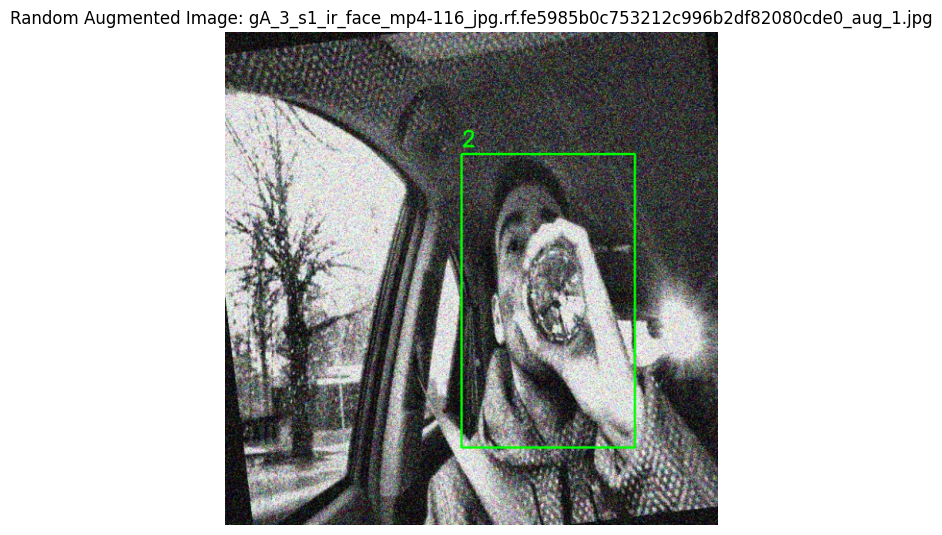

In [167]:
# YOLO 형식의 바운딩 박스를 OpenCV로 변환하여 시각화하는 함수
def visualize_random_augmented_image(image_dir, label_dir):
    # 'aug_0' 또는 'aug_1'이 포함된 이미지 파일 목록 가져오기
    img_files = [f for f in os.listdir(image_dir) if ('_aug_0' in f or '_aug_1' in f or '_aug_1' in f) and f.endswith('.jpg')]
    
    if not img_files:
        print("No augmented images found.")
        return
    
    # 랜덤 이미지 선택
    selected_img = random.choice(img_files)
    selected_lbl = selected_img.replace('.jpg', '.txt')
    
    img_path = os.path.join(image_dir, selected_img)
    lbl_path = os.path.join(label_dir, selected_lbl)
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV의 BGR을 RGB로 변환
    h, w, _ = image.shape
    
    # 바운딩 박스 시각화
    if os.path.exists(lbl_path):
        with open(lbl_path, 'r') as file:
            labels = file.readlines()
        
        for line in labels:
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])
            
            # YOLO 좌표를 이미지 좌표로 변환
            x_min = int((x_center - width / 2) * w)
            y_min = int((y_center - height / 2) * h)
            x_max = int((x_center + width / 2) * w)
            y_max = int((y_center + height / 2) * h)
            
            # 바운딩 박스 그리기
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image, str(class_id), (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    # 이미지 크기 조정 (640x640)
    image = cv2.resize(image, (640, 640))
    
    # 시각화
    plt.figure(figsize=(6.4, 6.4))  # 640x640 크기 유지
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Random Augmented Image: {selected_img}")
    plt.show()

# 데이터셋 경로 설정
image_dir = "/Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/images/"
label_dir = "/Volumes/G-DRIVE USB/dataset_all_calling_drinking_aug/train/labels/"

# 랜덤으로 이미지 시각화 실행
visualize_random_augmented_image(image_dir, label_dir)
